# Моделирование: Предсказание оттока клиентов

В этом ноутбуке мы:
1. Загрузим подготовленные данные (базовый и расширенный датасеты)
2. Применим **2 типа кодирования категориальных признаков**:
   - **LabelEncoder** - для tree-based и бустинговых моделей
   - **OneHotEncoder (drop_first=True)** - для линейных моделей (избегаем dummy variable trap)
3. Применим 2 стратегии:
   - **Простой Train-Test Split**
   - **SMOTENC для балансировки классов** (только для tree-based моделей)
4. Сравним модели на двух версиях данных:
   - **Базовый датасет** (исходные признаки)
   - **Расширенный датасет** (с engineered features)
5. Выберем лучшую модель

## Структура эксперимента:
- **Линейные модели**: Logistic Regression, SVM, KNN, Ridge, Lasso, LDA → используют **OneHotEncoder**
- **Tree-based модели**: Decision Tree, Random Forest, Naive Bayes → используют **LabelEncoder**
- **Бустинговые модели**: XGBoost, LightGBM, CatBoost, AdaBoost → используют **LabelEncoder**

In [15]:
# Основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn для моделирования
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Метрики
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, auc
)

# SMOTENC для балансировки классов (для mixed данных с категориальными признаками)
from imblearn.over_sampling import SMOTENC

# Бустинговые алгоритмы
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Настройки визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Загрузка данных

In [16]:
df_base = pd.read_csv('data/processed/base_dataset.csv')
df_enhanced = pd.read_csv('data/processed/enhanced_dataset.csv')


print("ЗАГРУЖЕННЫЕ ДАННЫЕ")

print(f"\nБазовая выборка: {df_base.shape}")
print(f"Расширенная выборка: {df_enhanced.shape}")

print(f"\nРаспределение целевой переменной:")
print(df_enhanced['Churn'].value_counts())
print(f"\nБаланс классов:")
churn_dist = df_enhanced['Churn'].value_counts(normalize=True) * 100
print(f"  No:  {churn_dist['No']:.1f}%")
print(f"  Yes: {churn_dist['Yes']:.1f}%")
print(f"\nДисбаланс классов: {churn_dist['No'] / churn_dist['Yes']:.2f}:1")

ЗАГРУЖЕННЫЕ ДАННЫЕ

Базовая выборка: (7043, 20)
Расширенная выборка: (7043, 26)

Распределение целевой переменной:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Баланс классов:
  No:  73.5%
  Yes: 26.5%

Дисбаланс классов: 2.77:1


## 3. Подготовка данных

In [17]:
print("ПОДГОТОВКА БАЗОВОГО ДАТАСЕТА")


df_base_prep = df_base.copy()

# Кодирование целевой переменной
df_base_prep['Churn'] = (df_base_prep['Churn'] == 'Yes').astype(int)

# Разделение на признаки и целевую переменную
X_base = df_base_prep.drop('Churn', axis=1)
y_base = df_base_prep['Churn']

# Кодирование категориальных признаков
categorical_cols_base = X_base.select_dtypes(include='object').columns.tolist()
print(f"\nКатегориальные признаки ({len(categorical_cols_base)}): {categorical_cols_base}")

# Сохраняем индексы категориальных признаков для SMOTENC
categorical_indices_base = [X_base.columns.get_loc(col) for col in categorical_cols_base]

label_encoders_base = {}
for col in categorical_cols_base:
    le = LabelEncoder()
    X_base[col] = le.fit_transform(X_base[col])
    label_encoders_base[col] = le

print(f"\nБазовый датасет подготовлен:")
print(f"   Размер X: {X_base.shape}")
print(f"   Размер y: {y_base.shape}")
print(f"   Количество признаков: {X_base.shape[1]}")
print(f"   Индексы категориальных признаков: {categorical_indices_base}")

ПОДГОТОВКА БАЗОВОГО ДАТАСЕТА

Категориальные признаки (15): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Базовый датасет подготовлен:
   Размер X: (7043, 19)
   Размер y: (7043,)
   Количество признаков: 19
   Индексы категориальных признаков: [0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [18]:
# Подготовка РАСШИРЕННОГО датасета
print("\nПОДГОТОВКА РАСШИРЕННОГО ДАТАСЕТА")

df_enhanced_prep = df_enhanced.copy()

# Кодирование целевой переменной
df_enhanced_prep['Churn'] = (df_enhanced_prep['Churn'] == 'Yes').astype(int)

# Разделение на признаки и целевую переменную
X_enhanced = df_enhanced_prep.drop('Churn', axis=1)
y_enhanced = df_enhanced_prep['Churn']

# Кодирование категориальных признаков
categorical_cols_enhanced = X_enhanced.select_dtypes(include='object').columns.tolist()
print(f"\nКатегориальные признаки ({len(categorical_cols_enhanced)}): {categorical_cols_enhanced}")

# Сохраняем индексы категориальных признаков для SMOTENC
categorical_indices_enhanced = [X_enhanced.columns.get_loc(col) for col in categorical_cols_enhanced]

label_encoders_enhanced = {}
for col in categorical_cols_enhanced:
    le = LabelEncoder()
    X_enhanced[col] = le.fit_transform(X_enhanced[col])
    label_encoders_enhanced[col] = le

print(f"\nРасширенный датасет подготовлен:")
print(f"   Размер X: {X_enhanced.shape}")
print(f"   Размер y: {y_enhanced.shape}")
print(f"   Количество признаков: {X_enhanced.shape[1]}")
print(f"   Индексы категориальных признаков: {categorical_indices_enhanced}")
print(f"\nДобавлено новых признаков: {X_enhanced.shape[1] - X_base.shape[1]}")


ПОДГОТОВКА РАСШИРЕННОГО ДАТАСЕТА

Категориальные признаки (16): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_category']

Расширенный датасет подготовлен:
   Размер X: (7043, 25)
   Размер y: (7043,)
   Количество признаков: 25
   Индексы категориальных признаков: [0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 24]

Добавлено новых признаков: 6


### 3.1. Подготовка данных с OneHotEncoding (для линейных моделей)

Для линейных моделей создадим отдельные версии данных с OneHotEncoding.  
**Важно:** используем `drop_first=True` чтобы избежать мультиколлинеарности (dummy variable trap).

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

print("ПОДГОТОВКА БАЗОВОГО ДАТАСЕТА С ONEHOTENCODING")

df_base_ohe = df_base.copy()
df_base_ohe['Churn'] = (df_base_ohe['Churn'] == 'Yes').astype(int)

X_base_ohe = df_base_ohe.drop('Churn', axis=1)
y_base_ohe = df_base_ohe['Churn']

# Определяем категориальные и числовые колонки
categorical_cols_base_ohe = X_base_ohe.select_dtypes(include='object').columns.tolist()
numerical_cols_base_ohe = X_base_ohe.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nКатегориальные признаки ({len(categorical_cols_base_ohe)}): {categorical_cols_base_ohe}")
print(f"Числовые признаки ({len(numerical_cols_base_ohe)}): {numerical_cols_base_ohe}")

# OneHotEncoder с drop_first=True (избегаем dummy variable trap)
ct_base = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False), categorical_cols_base_ohe),
    ('passthrough', 'passthrough', numerical_cols_base_ohe)
])

X_base_ohe_encoded = ct_base.fit_transform(X_base_ohe)

# Получаем названия признаков после OHE
ohe_feature_names = ct_base.named_transformers_['onehot'].get_feature_names_out(categorical_cols_base_ohe)
all_feature_names_base = list(ohe_feature_names) + numerical_cols_base_ohe
X_base_ohe_encoded = pd.DataFrame(X_base_ohe_encoded, columns=all_feature_names_base, index=X_base_ohe.index)

print(f"\nБазовый датасет с OHE подготовлен:")
print(f"   Размер X: {X_base_ohe_encoded.shape}")
print(f"   Было признаков (LabelEncoder): {X_base.shape[1]}")
print(f"   Стало признаков (OneHotEncoder): {X_base_ohe_encoded.shape[1]}")
print(f"   Добавлено признаков: +{X_base_ohe_encoded.shape[1] - X_base.shape[1]}")

ПОДГОТОВКА БАЗОВОГО ДАТАСЕТА С ONEHOTENCODING

Категориальные признаки (15): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Числовые признаки (4): ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

Базовый датасет с OHE подготовлен:
   Размер X: (7043, 30)
   Было признаков (LabelEncoder): 19
   Стало признаков (OneHotEncoder): 30
   Добавлено признаков: +11


In [20]:
# РАСШИРЕННЫЙ датасет с OneHotEncoding
print("\nПОДГОТОВКА РАСШИРЕННОГО ДАТАСЕТА С ONEHOTENCODING")

df_enhanced_ohe = df_enhanced.copy()
df_enhanced_ohe['Churn'] = (df_enhanced_ohe['Churn'] == 'Yes').astype(int)

X_enhanced_ohe = df_enhanced_ohe.drop('Churn', axis=1)
y_enhanced_ohe = df_enhanced_ohe['Churn']

# Определяем категориальные и числовые колонки
categorical_cols_enhanced_ohe = X_enhanced_ohe.select_dtypes(include='object').columns.tolist()
numerical_cols_enhanced_ohe = X_enhanced_ohe.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nКатегориальные признаки ({len(categorical_cols_enhanced_ohe)}): {categorical_cols_enhanced_ohe}")
print(f"Числовые признаки ({len(numerical_cols_enhanced_ohe)}): {numerical_cols_enhanced_ohe}")

# OneHotEncoder с drop_first=True (избегаем dummy variable trap)
ct_enhanced = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False), categorical_cols_enhanced_ohe),
    ('passthrough', 'passthrough', numerical_cols_enhanced_ohe)
])

X_enhanced_ohe_encoded = ct_enhanced.fit_transform(X_enhanced_ohe)

# Получаем названия признаков после OHE
ohe_feature_names_enhanced = ct_enhanced.named_transformers_['onehot'].get_feature_names_out(categorical_cols_enhanced_ohe)
all_feature_names_enhanced = list(ohe_feature_names_enhanced) + numerical_cols_enhanced_ohe
X_enhanced_ohe_encoded = pd.DataFrame(X_enhanced_ohe_encoded, columns=all_feature_names_enhanced, index=X_enhanced_ohe.index)

print(f"\nРасширенный датасет с OHE подготовлен:")
print(f"   Размер X: {X_enhanced_ohe_encoded.shape}")
print(f"   Было признаков (LabelEncoder): {X_enhanced.shape[1]}")
print(f"   Стало признаков (OneHotEncoder): {X_enhanced_ohe_encoded.shape[1]}")
print(f"   Добавлено признаков: +{X_enhanced_ohe_encoded.shape[1] - X_enhanced.shape[1]}")


ПОДГОТОВКА РАСШИРЕННОГО ДАТАСЕТА С ONEHOTENCODING

Категориальные признаки (16): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_category']
Числовые признаки (9): ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'total_services', 'has_automatic_payment', 'is_new_customer', 'has_protection_services', 'charge_per_month_tenure']

Расширенный датасет с OHE подготовлен:
   Размер X: (7043, 31)
   Было признаков (LabelEncoder): 25
   Стало признаков (OneHotEncoder): 31
   Добавлено признаков: +6


## 4. Вспомогательные функции

In [21]:
def train_and_evaluate(models, X_train, X_test, y_train, y_test, strategy_name="", use_grid_search=False, cv_folds=5):
    """
    Обучает и оценивает список моделей
    
    Parameters:
    -----------
    models : dict
        Словарь {название: (модель, параметры для GridSearch)}
    X_train, X_test, y_train, y_test : массивы
        Данные для обучения и тестирования
    strategy_name : str
        Название стратегии
    use_grid_search : bool
        Использовать ли GridSearchCV
    cv_folds : int
        Количество фолдов для кросс-валидации
    
    Returns:
    --------
    pd.DataFrame : Результаты оценки моделей
    """
    results = []
    
    print(f"\n{strategy_name}")
    if use_grid_search:
        print(f"GridSearchCV + StratifiedKFold (n_splits={cv_folds})")
    else:
        print(f"Быстрое обучение без GridSearchCV")
    print(f"{'='*80}\n")
    
    # Масштабирование признаков для линейных моделей
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42) if use_grid_search else None
    
    for name, (model, params) in models.items():
        print(f"\nОбучение: {name}...")
        
        try:
            if use_grid_search and params:
                # GridSearchCV с StratifiedKFold
                grid_search = GridSearchCV(
                    estimator=model,
                    param_grid=params,
                    cv=skf,
                    scoring='f1',
                    n_jobs=-1,
                    verbose=0
                )
                grid_search.fit(X_train_scaled, y_train)
                best_model = grid_search.best_estimator_
                print(f"  Лучшие параметры: {grid_search.best_params_}")
            else:
                # Обычное обучение
                best_model = model
                best_model.fit(X_train_scaled, y_train)
            
            # Предсказания
            y_pred = best_model.predict(X_test_scaled)
            y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model, 'predict_proba') else None
            
            # Метрики
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
            
            roc_auc_str = f"{roc_auc:.4f}" if roc_auc is not None else "N/A"
            print(f"  Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc_str}")
            
            results.append({
                'Model': name,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'ROC-AUC': roc_auc
            })
            
        except Exception as e:
            print(f"  Ошибка при обучении {name}: {str(e)}")
    
    return pd.DataFrame(results).sort_values('F1-Score', ascending=False)

In [53]:
def train_boosting_models(X_train, X_test, y_train, y_test, strategy_name="", use_grid_search=False, cv_folds=5):
    """
    Обучает бустинговые модели
    
    Parameters:
    -----------
    X_train, X_test, y_train, y_test : массивы
        Данные для обучения и тестирования
    strategy_name : str
        Название стратегии
    use_grid_search : bool
        Использовать ли GridSearchCV
    cv_folds : int
        Количество фолдов для кросс-валидации
    
    Returns:
    --------
    pd.DataFrame : Результаты оценки моделей
    """
    results = []
    
    print(f"\nБУСТИНГОВЫЕ МОДЕЛИ - {strategy_name}")
    if use_grid_search:
        print(f"GridSearchCV + StratifiedKFold (n_splits={cv_folds})")
    else:
        print(f"Быстрое обучение без GridSearchCV")
    print(f"{'='*80}\n")
    
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42) if use_grid_search else None
    
    # Словарь моделей и их  параметров
    models_params = {
        'AdaBoost': {
            'model': AdaBoostClassifier(random_state=42, algorithm='SAMME'),
            'params': {
                'n_estimators': [200, 300, 500],
                'learning_rate': [0.01, 0.1, 0.5, 1.0]
            } if use_grid_search else {}
        },
        'XGBoost': {
            'model': XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
            'params': {
                'n_estimators': [200, 300, 500],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7],
                'min_child_weight': [1, 3, 5],
                'subsample': [0.8, 1.0],
                'colsample_bytree': [0.8, 1.0]
            } if use_grid_search else {}
        },
        'LightGBM': {
            'model': LGBMClassifier(random_state=42, verbose=-1),
            'params': {
                'n_estimators': [200],
                'learning_rate': [0.1],
                'max_depth': [7],
                'num_leaves': [45]
            } if use_grid_search else {}
        },
        'CatBoost': {
            'model': CatBoostClassifier(random_state=42, verbose=0),
            'params': {
                'iterations': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'depth': [4, 6, 8],
                'l2_leaf_reg': [1, 3, 5, 7]
            } if use_grid_search else {}
        }
    }
    
    for name, config in models_params.items():
        print(f"\nОбучение: {name}...")
        
        try:
            if use_grid_search and config['params']:
                # GridSearchCV с StratifiedKFold
                grid_search = GridSearchCV(
                    estimator=config['model'],
                    param_grid=config['params'],
                    cv=skf,
                    scoring='f1',
                    n_jobs=-1,
                    verbose=0
                )
                grid_search.fit(X_train, y_train)
                best_model = grid_search.best_estimator_
                print(f"  Лучшие параметры: {grid_search.best_params_}")
            else:
                # Обычное обучение
                best_model = config['model']
                best_model.fit(X_train, y_train)
            
            # Предсказания
            y_pred = best_model.predict(X_test)
            y_pred_proba = best_model.predict_proba(X_test)[:, 1]
            
            # Метрики
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            
            print(f"  Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc:.4f}")
            
            results.append({
                'Model': name,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'ROC-AUC': roc_auc
            })
            
        except Exception as e:
            print(f"  Ошибка при обучении {name}: {str(e)}")
    
    return pd.DataFrame(results).sort_values('F1-Score', ascending=False)

In [23]:
def train_and_evaluate_with_predictions(models, X_train, X_test, y_train, y_test, strategy_name="", use_grid_search=False, cv_folds=5):
    """
    Обучает модели и возвращает результаты вместе с предсказаниями для визуализации
    
    Returns:
    --------
    tuple: (DataFrame с метриками, dict с предсказаниями)
    """
    results = []
    predictions_dict = {}
    
    print(f"\n{strategy_name}")
    if use_grid_search:
        print(f"GridSearchCV + StratifiedKFold (n_splits={cv_folds})")
    else:
        print(f"Быстрое обучение без GridSearchCV")
    print(f"{'='*80}\n")
    
    # Масштабирование признаков для линейных моделей
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42) if use_grid_search else None
    
    for name, (model, params) in models.items():
        print(f"\nОбучение: {name}...")
        
        try:
            if use_grid_search and params:
                grid_search = GridSearchCV(
                    estimator=model,
                    param_grid=params,
                    cv=skf,
                    scoring='f1',
                    n_jobs=-1,
                    verbose=0
                )
                grid_search.fit(X_train_scaled, y_train)
                best_model = grid_search.best_estimator_
                print(f"  Лучшие параметры: {grid_search.best_params_}")
            else:
                best_model = model
                best_model.fit(X_train_scaled, y_train)
            
            # Предсказания
            y_pred = best_model.predict(X_test_scaled)
            y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model, 'predict_proba') else None
            
            # Метрики
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
            
            roc_auc_str = f"{roc_auc:.4f}" if roc_auc is not None else "N/A"
            print(f"  Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc_str}")
            
            results.append({
                'Model': name,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'ROC-AUC': roc_auc
            })
            
            # Сохраняем предсказания для визуализации
            predictions_dict[name] = {
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba,
                'metrics': {
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Recall': recall,
                    'F1-Score': f1,
                    'ROC-AUC': roc_auc
                }
            }
            
        except Exception as e:
            print(f"  Ошибка при обучении {name}: {str(e)}")
    
    return pd.DataFrame(results).sort_values('F1-Score', ascending=False), predictions_dict


def plot_confusion_matrices(results_dict, y_test, strategy_name):
    """
    Визуализация матриц ошибок для ТОП-6 моделей по F1-Score
    """
    # Сортируем модели по F1-Score
    sorted_models = sorted(results_dict.items(), 
                          key=lambda x: x[1]['metrics']['F1-Score'], 
                          reverse=True)[:6]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Матрицы ошибок (ТОП-6 моделей по F1-Score) - {strategy_name}', 
                 fontsize=14, fontweight='bold')
    
    for idx, (model_name, data) in enumerate(sorted_models):
        row = idx // 3
        col = idx % 3
        cm = confusion_matrix(y_test, data['y_pred'])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col],
                   xticklabels=['No Churn', 'Churn'],
                   yticklabels=['No Churn', 'Churn'])
        axes[row, col].set_title(f"{model_name}\nF1: {data['metrics']['F1-Score']:.3f}", 
                                 fontweight='bold', fontsize=10)
        axes[row, col].set_ylabel('Истинные значения')
        axes[row, col].set_xlabel('Предсказанные значения')
    
    plt.tight_layout()
    plt.show()


def plot_roc_curves(results_dict, y_test, strategy_name):
    """
    Визуализация ROC-кривых для ТОП-10 моделей по ROC-AUC
    """
    # Фильтруем модели с predict_proba и сортируем по ROC-AUC
    models_with_proba = [(name, data) for name, data in results_dict.items() 
                         if data['y_pred_proba'] is not None and data['metrics']['ROC-AUC'] is not None]
    
    sorted_models = sorted(models_with_proba, 
                          key=lambda x: x[1]['metrics']['ROC-AUC'], 
                          reverse=True)[:10]
    
    plt.figure(figsize=(12, 8))
    
    for model_name, data in sorted_models:
        fpr, tpr, _ = roc_curve(y_test, data['y_pred_proba'])
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC-кривые (ТОП-10 моделей) - {strategy_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## 5. Определение моделей

In [24]:
# ЛИНЕЙНЫЕ МОДЕЛИ (используют OneHotEncoder данные)
linear_models = {
    'Logistic Regression': (
        LogisticRegression(random_state=42, max_iter=1000),
        {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
    ),
    'SVM': (
        SVC(random_state=42, probability=True),
        {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto']}
    ),
    'KNN': (
        KNeighborsClassifier(),
        {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
    ),
    'LDA': (
        LinearDiscriminantAnalysis(),
        {}
    )
}

# TREE-BASED МОДЕЛИ (используют LabelEncoder данные)
tree_models = {
    'Decision Tree': (
        DecisionTreeClassifier(random_state=42),
        {'max_depth': [3, 5, 7, 10, None], 'min_samples_split': [2, 5, 10]}
    ),
    'Random Forest': (
        RandomForestClassifier(random_state=42),
        {'n_estimators': [200, 300, 500], 'max_depth': [5, 10,15, None], 'min_samples_split': [2, 5]}
    ),
    'Naive Bayes (Gaussian)': (
        GaussianNB(),
        {}
    ),
    'Naive Bayes (Bernoulli)': (
        BernoulliNB(),
        {'alpha': [0.1, 0.5, 1.0]}
    )
}

print(f"Определено {len(linear_models)} линейных моделей (для OHE данных):")
for name in linear_models.keys():
    print(f"  - {name}")

print(f"\nОпределено {len(tree_models)} tree-based моделей (для LabelEncoder данных):")
for name in tree_models.keys():
    print(f"  - {name}")

print(f"\nВсего базовых моделей: {len(linear_models) + len(tree_models)}")

Определено 4 линейных моделей (для OHE данных):
  - Logistic Regression
  - SVM
  - KNN
  - LDA

Определено 4 tree-based моделей (для LabelEncoder данных):
  - Decision Tree
  - Random Forest
  - Naive Bayes (Gaussian)
  - Naive Bayes (Bernoulli)

Всего базовых моделей: 8


## 6. Стратегия 1: Простой Train-Test Split на базовом датасете

In [25]:
print("ПРОСТОЙ TRAIN-TEST SPLIT - БАЗОВЫЙ ДАТАСЕТ")

# Разделение LabelEncoder данных (для tree-based моделей)
X_train_base_simple_le, X_test_base_simple_le, y_train_base_simple, y_test_base_simple = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42
)

# Разделение OneHotEncoder данных (для линейных моделей)
X_train_base_simple_ohe, X_test_base_simple_ohe, _, _ = train_test_split(
    X_base_ohe_encoded, y_base_ohe, test_size=0.2, random_state=42
)

print(f"\nLabelEncoder данные (tree-based модели):")
print(f"  Обучающая выборка: {X_train_base_simple_le.shape}")
print(f"  Тестовая выборка: {X_test_base_simple_le.shape}")

print(f"\nOneHotEncoder данные (линейные модели):")
print(f"  Обучающая выборка: {X_train_base_simple_ohe.shape}")
print(f"  Тестовая выборка: {X_test_base_simple_ohe.shape}")

print(f"\nРаспределение классов в обучающей выборке:")
print(y_train_base_simple.value_counts(normalize=True))
print(f"\nРаспределение классов в тестовой выборке:")
print(y_test_base_simple.value_counts(normalize=True))

ПРОСТОЙ TRAIN-TEST SPLIT - БАЗОВЫЙ ДАТАСЕТ

LabelEncoder данные (tree-based модели):
  Обучающая выборка: (5634, 19)
  Тестовая выборка: (1409, 19)

OneHotEncoder данные (линейные модели):
  Обучающая выборка: (5634, 30)
  Тестовая выборка: (1409, 30)

Распределение классов в обучающей выборке:
Churn
0    0.734469
1    0.265531
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
Churn
0    0.735273
1    0.264727
Name: proportion, dtype: float64


In [26]:
# Обучение ЛИНЕЙНЫХ моделей на OneHotEncoder данных
results_base_simple_linear = train_and_evaluate(
    linear_models,
    X_train_base_simple_ohe, X_test_base_simple_ohe,
    y_train_base_simple, y_test_base_simple,
    strategy_name="Базовый датасет - Простой Split - ЛИНЕЙНЫЕ МОДЕЛИ (OHE)",
    use_grid_search=False
)

# Обучение TREE-BASED моделей на LabelEncoder данных
results_base_simple_tree = train_and_evaluate(
    tree_models,
    X_train_base_simple_le, X_test_base_simple_le,
    y_train_base_simple, y_test_base_simple,
    strategy_name="Базовый датасет - Простой Split - TREE-BASED МОДЕЛИ (LE)",
    use_grid_search=False
)

# Объединяем результаты
results_base_simple = pd.concat([results_base_simple_linear, results_base_simple_tree], ignore_index=True)
results_base_simple = results_base_simple.sort_values('F1-Score', ascending=False)

print("\nИТОГОВЫЕ РЕЗУЛЬТАТЫ (отсортированы по F1-Score):")
print(results_base_simple.to_string(index=False))


Базовый датасет - Простой Split - ЛИНЕЙНЫЕ МОДЕЛИ (OHE)
Быстрое обучение без GridSearchCV


Обучение: Logistic Regression...
  Accuracy: 0.8197 | Precision: 0.6831 | Recall: 0.5952 | F1: 0.6361 | ROC-AUC: 0.8620

Обучение: SVM...
  Accuracy: 0.8141 | Precision: 0.6934 | Recall: 0.5335 | F1: 0.6030 | ROC-AUC: 0.8230

Обучение: KNN...
  Accuracy: 0.7715 | Precision: 0.5757 | Recall: 0.5201 | F1: 0.5465 | ROC-AUC: 0.7902

Обучение: LDA...
  Accuracy: 0.8133 | Precision: 0.6618 | Recall: 0.6032 | F1: 0.6311 | ROC-AUC: 0.8564

Базовый датасет - Простой Split - TREE-BASED МОДЕЛИ (LE)
Быстрое обучение без GridSearchCV


Обучение: Decision Tree...
  Accuracy: 0.7260 | Precision: 0.4835 | Recall: 0.5094 | F1: 0.4961 | ROC-AUC: 0.6584

Обучение: Random Forest...
  Accuracy: 0.7963 | Precision: 0.6641 | Recall: 0.4665 | F1: 0.5480 | ROC-AUC: 0.8370

Обучение: Naive Bayes (Gaussian)...
  Accuracy: 0.7580 | Precision: 0.5293 | Recall: 0.7748 | F1: 0.6289 | ROC-AUC: 0.8429

Обучение: Naive Bayes (B

In [27]:
# Бустинговые модели (используют LabelEncoder данные)
results_base_simple_boosting = train_boosting_models(
    X_train_base_simple_le, X_test_base_simple_le,
    y_train_base_simple, y_test_base_simple,
    strategy_name="Базовый датасет - Простой Split",
    use_grid_search=False  # Установите True для GridSearchCV
)

print("\nРезультаты бустинговых моделей:")
print(results_base_simple_boosting.to_string(index=False))


БУСТИНГОВЫЕ МОДЕЛИ - Базовый датасет - Простой Split
Быстрое обучение без GridSearchCV


Обучение: AdaBoost...
  Accuracy: 0.8062 | Precision: 0.6623 | Recall: 0.5469 | F1: 0.5991 | ROC-AUC: 0.8591

Обучение: XGBoost...
  Accuracy: 0.7942 | Precision: 0.6361 | Recall: 0.5201 | F1: 0.5723 | ROC-AUC: 0.8365

Обучение: LightGBM...
  Accuracy: 0.8077 | Precision: 0.6667 | Recall: 0.5469 | F1: 0.6009 | ROC-AUC: 0.8577

Обучение: CatBoost...
  Accuracy: 0.8034 | Precision: 0.6611 | Recall: 0.5282 | F1: 0.5872 | ROC-AUC: 0.8561

Результаты бустинговых моделей:
   Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
LightGBM  0.807665   0.666667 0.546917  0.600884 0.857686
AdaBoost  0.806246   0.662338 0.546917  0.599119 0.859129
CatBoost  0.803407   0.661074 0.528150  0.587183 0.856119
 XGBoost  0.794180   0.636066 0.520107  0.572271 0.836456


## 7. Стратегия 1: Простой Train-Test Split на расширенном датасете

In [28]:
print("ПРОСТОЙ TRAIN-TEST SPLIT - РАСШИРЕННЫЙ ДАТАСЕТ")

# Разделение LabelEncoder данных (для tree-based моделей)
X_train_enhanced_simple_le, X_test_enhanced_simple_le, y_train_enhanced_simple, y_test_enhanced_simple = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42
)

# Разделение OneHotEncoder данных (для линейных моделей)
X_train_enhanced_simple_ohe, X_test_enhanced_simple_ohe, _, _ = train_test_split(
    X_enhanced_ohe_encoded, y_enhanced_ohe, test_size=0.2, random_state=42
)

print(f"\nLabelEncoder данные (tree-based модели):")
print(f"  Обучающая выборка: {X_train_enhanced_simple_le.shape}")
print(f"  Тестовая выборка: {X_test_enhanced_simple_le.shape}")

print(f"\nOneHotEncoder данные (линейные модели):")
print(f"  Обучающая выборка: {X_train_enhanced_simple_ohe.shape}")
print(f"  Тестовая выборка: {X_test_enhanced_simple_ohe.shape}")

print(f"\nРаспределение классов в обучающей выборке:")
print(y_train_enhanced_simple.value_counts(normalize=True))
print(f"\nРаспределение классов в тестовой выборке:")
print(y_test_enhanced_simple.value_counts(normalize=True))



ПРОСТОЙ TRAIN-TEST SPLIT - РАСШИРЕННЫЙ ДАТАСЕТ

LabelEncoder данные (tree-based модели):
  Обучающая выборка: (5634, 25)
  Тестовая выборка: (1409, 25)

OneHotEncoder данные (линейные модели):
  Обучающая выборка: (5634, 31)
  Тестовая выборка: (1409, 31)

Распределение классов в обучающей выборке:
Churn
0    0.734469
1    0.265531
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
Churn
0    0.735273
1    0.264727
Name: proportion, dtype: float64


In [29]:
# Обучение ЛИНЕЙНЫХ моделей на OneHotEncoder данных
results_enhanced_simple_linear = train_and_evaluate(
    linear_models,
    X_train_enhanced_simple_ohe, X_test_enhanced_simple_ohe,
    y_train_enhanced_simple, y_test_enhanced_simple,
    strategy_name="Расширенный датасет - Простой Split - ЛИНЕЙНЫЕ МОДЕЛИ (OHE)",
    use_grid_search=False
)

# Обучение TREE-BASED моделей на LabelEncoder данных
results_enhanced_simple_tree = train_and_evaluate(
    tree_models,
    X_train_enhanced_simple_le, X_test_enhanced_simple_le,
    y_train_enhanced_simple, y_test_enhanced_simple,
    strategy_name="Расширенный датасет - Простой Split - TREE-BASED МОДЕЛИ (LE)",
    use_grid_search=False
)

# Объединяем результаты
results_enhanced_simple = pd.concat([results_enhanced_simple_linear, results_enhanced_simple_tree], ignore_index=True)
results_enhanced_simple = results_enhanced_simple.sort_values('F1-Score', ascending=False)

print("\nИТОГОВЫЕ РЕЗУЛЬТАТЫ (отсортированы по F1-Score):")
print(results_enhanced_simple.to_string(index=False))


Расширенный датасет - Простой Split - ЛИНЕЙНЫЕ МОДЕЛИ (OHE)
Быстрое обучение без GridSearchCV


Обучение: Logistic Regression...
  Accuracy: 0.8098 | Precision: 0.6667 | Recall: 0.5630 | F1: 0.6105 | ROC-AUC: 0.8613

Обучение: SVM...
  Accuracy: 0.8062 | Precision: 0.6908 | Recall: 0.4853 | F1: 0.5701 | ROC-AUC: 0.8182

Обучение: KNN...
  Accuracy: 0.7779 | Precision: 0.5938 | Recall: 0.5094 | F1: 0.5483 | ROC-AUC: 0.7940

Обучение: LDA...
  Accuracy: 0.8062 | Precision: 0.6634 | Recall: 0.5442 | F1: 0.5979 | ROC-AUC: 0.8582

Расширенный датасет - Простой Split - TREE-BASED МОДЕЛИ (LE)
Быстрое обучение без GridSearchCV


Обучение: Decision Tree...
  Accuracy: 0.7182 | Precision: 0.4694 | Recall: 0.4933 | F1: 0.4810 | ROC-AUC: 0.6468

Обучение: Random Forest...
  Accuracy: 0.7935 | Precision: 0.6577 | Recall: 0.4584 | F1: 0.5403 | ROC-AUC: 0.8330

Обучение: Naive Bayes (Gaussian)...
  Accuracy: 0.7559 | Precision: 0.5276 | Recall: 0.7426 | F1: 0.6169 | ROC-AUC: 0.8326

Обучение: Naive 

In [30]:
# Бустинговые модели (используют LabelEncoder данные)
results_enhanced_simple_boosting = train_boosting_models(
    X_train_enhanced_simple_le, X_test_enhanced_simple_le,
    y_train_enhanced_simple, y_test_enhanced_simple,
    strategy_name="Расширенный датасет - Простой Split",
    use_grid_search=False
)

print("\nРезультаты бустинговых моделей:")
print(results_enhanced_simple_boosting.to_string(index=False))


БУСТИНГОВЫЕ МОДЕЛИ - Расширенный датасет - Простой Split
Быстрое обучение без GridSearchCV


Обучение: AdaBoost...
  Accuracy: 0.8077 | Precision: 0.6700 | Recall: 0.5389 | F1: 0.5973 | ROC-AUC: 0.8576

Обучение: XGBoost...
  Accuracy: 0.7949 | Precision: 0.6346 | Recall: 0.5308 | F1: 0.5781 | ROC-AUC: 0.8325

Обучение: LightGBM...
  Accuracy: 0.8006 | Precision: 0.6533 | Recall: 0.5255 | F1: 0.5825 | ROC-AUC: 0.8503

Обучение: CatBoost...
  Accuracy: 0.8055 | Precision: 0.6725 | Recall: 0.5174 | F1: 0.5848 | ROC-AUC: 0.8545

Результаты бустинговых моделей:
   Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
AdaBoost  0.807665   0.670000 0.538874  0.597325 0.857559
CatBoost  0.805536   0.672474 0.517426  0.584848 0.854454
LightGBM  0.800568   0.653333 0.525469  0.582467 0.850279
 XGBoost  0.794890   0.634615 0.530831  0.578102 0.832476


## 8. Стратегия 2: SMOTENC Split на базовом датасете

SMOTENC применяется **ПОСЛЕ** train_test_split только к обучающей выборке.

In [31]:
print("SMOTENC SPLIT - БАЗОВЫЙ ДАТАСЕТ")

# Сначала делаем обычный train_test_split для LabelEncoder данных
X_train_base_smotenc_le, X_test_base_smotenc_le, y_train_base_smotenc, y_test_base_smotenc = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42
)

# Разделение OneHotEncoder данных (для линейных моделей) - БЕЗ SMOTENC
X_train_base_smotenc_ohe, X_test_base_smotenc_ohe, _, _ = train_test_split(
    X_base_ohe_encoded, y_base_ohe, test_size=0.2, random_state=42
)

print(f"\nДо SMOTENC (LabelEncoder данные):")
print(f"  Обучающая выборка: {X_train_base_smotenc_le.shape}")
print(f"  Распределение классов: {y_train_base_smotenc.value_counts().to_dict()}")

# Применяем SMOTENC ПОСЛЕ split только к LabelEncoder данным
smotenc_base = SMOTENC(categorical_features=categorical_indices_base, random_state=42)
X_train_base_smotenc_le_resampled, y_train_base_smotenc_resampled = smotenc_base.fit_resample(
    X_train_base_smotenc_le, y_train_base_smotenc
)

print(f"\nПосле SMOTENC (LabelEncoder данные):")
print(f"  Обучающая выборка: {X_train_base_smotenc_le_resampled.shape}")
print(f"  Распределение классов: {pd.Series(y_train_base_smotenc_resampled).value_counts().to_dict()}")

print(f"\nOneHotEncoder данные (линейные модели) - БЕЗ SMOTENC:")
print(f"  Обучающая выборка: {X_train_base_smotenc_ohe.shape}")
print(f"  Распределение классов (исходное): {y_train_base_smotenc.value_counts().to_dict()}")

print(f"\nТестовая выборка НЕ изменилась:")
print(f"  LabelEncoder: {X_test_base_smotenc_le.shape}")
print(f"  OneHotEncoder: {X_test_base_smotenc_ohe.shape}")
print(f"  Распределение классов: {y_test_base_smotenc.value_counts().to_dict()}")

SMOTENC SPLIT - БАЗОВЫЙ ДАТАСЕТ

До SMOTENC (LabelEncoder данные):
  Обучающая выборка: (5634, 19)
  Распределение классов: {0: 4138, 1: 1496}

После SMOTENC (LabelEncoder данные):
  Обучающая выборка: (8276, 19)
  Распределение классов: {0: 4138, 1: 4138}

OneHotEncoder данные (линейные модели) - БЕЗ SMOTENC:
  Обучающая выборка: (5634, 30)
  Распределение классов (исходное): {0: 4138, 1: 1496}

Тестовая выборка НЕ изменилась:
  LabelEncoder: (1409, 19)
  OneHotEncoder: (1409, 30)
  Распределение классов: {0: 1036, 1: 373}


In [32]:
# Обучение ЛИНЕЙНЫХ моделей на OneHotEncoder данных (БЕЗ SMOTENC)
results_base_smotenc_linear = train_and_evaluate(
    linear_models,
    X_train_base_smotenc_ohe, X_test_base_smotenc_ohe,
    y_train_base_smotenc, y_test_base_smotenc,
    strategy_name="Базовый датасет - БЕЗ SMOTENC - ЛИНЕЙНЫЕ МОДЕЛИ (OHE)",
    use_grid_search=False
)

# Обучение TREE-BASED моделей на LabelEncoder данных с SMOTENC
results_base_smotenc_tree = train_and_evaluate(
    tree_models,
    X_train_base_smotenc_le_resampled, X_test_base_smotenc_le,
    y_train_base_smotenc_resampled, y_test_base_smotenc,
    strategy_name="Базовый датасет - SMOTENC - TREE-BASED МОДЕЛИ (LE)",
    use_grid_search=False
)

# Объединяем результаты
results_base_smotenc = pd.concat([results_base_smotenc_linear, results_base_smotenc_tree], ignore_index=True)
results_base_smotenc = results_base_smotenc.sort_values('F1-Score', ascending=False)

print("\nИТОГОВЫЕ РЕЗУЛЬТАТЫ (отсортированы по F1-Score):")
print(results_base_smotenc.to_string(index=False))


Базовый датасет - БЕЗ SMOTENC - ЛИНЕЙНЫЕ МОДЕЛИ (OHE)
Быстрое обучение без GridSearchCV


Обучение: Logistic Regression...
  Accuracy: 0.8197 | Precision: 0.6831 | Recall: 0.5952 | F1: 0.6361 | ROC-AUC: 0.8620

Обучение: SVM...
  Accuracy: 0.8141 | Precision: 0.6934 | Recall: 0.5335 | F1: 0.6030 | ROC-AUC: 0.8230

Обучение: KNN...
  Accuracy: 0.7715 | Precision: 0.5757 | Recall: 0.5201 | F1: 0.5465 | ROC-AUC: 0.7902

Обучение: LDA...
  Accuracy: 0.8133 | Precision: 0.6618 | Recall: 0.6032 | F1: 0.6311 | ROC-AUC: 0.8564

Базовый датасет - SMOTENC - TREE-BASED МОДЕЛИ (LE)
Быстрое обучение без GridSearchCV


Обучение: Decision Tree...
  Accuracy: 0.7140 | Precision: 0.4662 | Recall: 0.5550 | F1: 0.5067 | ROC-AUC: 0.6627

Обучение: Random Forest...
  Accuracy: 0.7757 | Precision: 0.5760 | Recall: 0.5791 | F1: 0.5775 | ROC-AUC: 0.8282

Обучение: Naive Bayes (Gaussian)...
  Accuracy: 0.7566 | Precision: 0.5285 | Recall: 0.7453 | F1: 0.6185 | ROC-AUC: 0.8356

Обучение: Naive Bayes (Bernoulli

In [33]:
# Бустинговые модели (используют LabelEncoder данные с SMOTENC)
results_base_smotenc_boosting = train_boosting_models(
    X_train_base_smotenc_le_resampled, X_test_base_smotenc_le,
    y_train_base_smotenc_resampled, y_test_base_smotenc,
    strategy_name="Базовый датасет - SMOTENC Split",
    use_grid_search=False
)

print("\nРезультаты бустинговых моделей:")
print(results_base_smotenc_boosting.to_string(index=False))


БУСТИНГОВЫЕ МОДЕЛИ - Базовый датасет - SMOTENC Split
Быстрое обучение без GridSearchCV


Обучение: AdaBoost...
  Accuracy: 0.7587 | Precision: 0.5302 | Recall: 0.7775 | F1: 0.6304 | ROC-AUC: 0.8472

Обучение: XGBoost...
  Accuracy: 0.7892 | Precision: 0.5969 | Recall: 0.6273 | F1: 0.6118 | ROC-AUC: 0.8307

Обучение: LightGBM...
  Accuracy: 0.7857 | Precision: 0.5839 | Recall: 0.6622 | F1: 0.6206 | ROC-AUC: 0.8389

Обучение: CatBoost...
  Accuracy: 0.7892 | Precision: 0.5896 | Recall: 0.6702 | F1: 0.6274 | ROC-AUC: 0.8471

Результаты бустинговых моделей:
   Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
AdaBoost  0.758694   0.530165 0.777480  0.630435 0.847160
CatBoost  0.789212   0.589623 0.670241  0.627353 0.847140
LightGBM  0.785664   0.583924 0.662198  0.620603 0.838877
 XGBoost  0.789212   0.596939 0.627346  0.611765 0.830719


## 9. Стратегия 2: SMOTENC Split на расширенном датасете

In [34]:
print("SMOTENC SPLIT - РАСШИРЕННЫЙ ДАТАСЕТ")

# Сначала делаем обычный train_test_split для LabelEncoder данных
X_train_enhanced_smotenc_le, X_test_enhanced_smotenc_le, y_train_enhanced_smotenc, y_test_enhanced_smotenc = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42
)

# Разделение OneHotEncoder данных (для линейных моделей) - БЕЗ SMOTENC
X_train_enhanced_smotenc_ohe, X_test_enhanced_smotenc_ohe, _, _ = train_test_split(
    X_enhanced_ohe_encoded, y_enhanced_ohe, test_size=0.2, random_state=42
)

print(f"\nДо SMOTENC (LabelEncoder данные):")
print(f"  Обучающая выборка: {X_train_enhanced_smotenc_le.shape}")
print(f"  Распределение классов: {y_train_enhanced_smotenc.value_counts().to_dict()}")

# Применяем SMOTENC ПОСЛЕ split только к LabelEncoder данным
smotenc_enhanced = SMOTENC(categorical_features=categorical_indices_enhanced, random_state=42)
X_train_enhanced_smotenc_le_resampled, y_train_enhanced_smotenc_resampled = smotenc_enhanced.fit_resample(
    X_train_enhanced_smotenc_le, y_train_enhanced_smotenc
)

print(f"\nПосле SMOTENC (LabelEncoder данные):")
print(f"  Обучающая выборка: {X_train_enhanced_smotenc_le_resampled.shape}")
print(f"  Распределение классов: {pd.Series(y_train_enhanced_smotenc_resampled).value_counts().to_dict()}")

print(f"\nOneHotEncoder данные (линейные модели) - БЕЗ SMOTENC:")
print(f"  Обучающая выборка: {X_train_enhanced_smotenc_ohe.shape}")
print(f"  Распределение классов (исходное): {y_train_enhanced_smotenc.value_counts().to_dict()}")

print(f"\nТестовая выборка НЕ изменилась:")
print(f"  LabelEncoder: {X_test_enhanced_smotenc_le.shape}")
print(f"  OneHotEncoder: {X_test_enhanced_smotenc_ohe.shape}")
print(f"  Распределение классов: {y_test_enhanced_smotenc.value_counts().to_dict()}")

SMOTENC SPLIT - РАСШИРЕННЫЙ ДАТАСЕТ

До SMOTENC (LabelEncoder данные):
  Обучающая выборка: (5634, 25)
  Распределение классов: {0: 4138, 1: 1496}

После SMOTENC (LabelEncoder данные):
  Обучающая выборка: (8276, 25)
  Распределение классов: {0: 4138, 1: 4138}

OneHotEncoder данные (линейные модели) - БЕЗ SMOTENC:
  Обучающая выборка: (5634, 31)
  Распределение классов (исходное): {0: 4138, 1: 1496}

Тестовая выборка НЕ изменилась:
  LabelEncoder: (1409, 25)
  OneHotEncoder: (1409, 31)
  Распределение классов: {0: 1036, 1: 373}


In [35]:
# Обучение ЛИНЕЙНЫХ моделей на OneHotEncoder данных (БЕЗ SMOTENC)
results_enhanced_smotenc_linear = train_and_evaluate(
    linear_models,
    X_train_enhanced_smotenc_ohe, X_test_enhanced_smotenc_ohe,
    y_train_enhanced_smotenc, y_test_enhanced_smotenc,
    strategy_name="Расширенный датасет - БЕЗ SMOTENC - ЛИНЕЙНЫЕ МОДЕЛИ (OHE)",
    use_grid_search=False
)

# Обучение TREE-BASED моделей на LabelEncoder данных с SMOTENC
results_enhanced_smotenc_tree = train_and_evaluate(
    tree_models,
    X_train_enhanced_smotenc_le_resampled, X_test_enhanced_smotenc_le,
    y_train_enhanced_smotenc_resampled, y_test_enhanced_smotenc,
    strategy_name="Расширенный датасет - SMOTENC - TREE-BASED МОДЕЛИ (LE)",
    use_grid_search=False
)

# Объединяем результаты
results_enhanced_smotenc = pd.concat([results_enhanced_smotenc_linear, results_enhanced_smotenc_tree], ignore_index=True)
results_enhanced_smotenc = results_enhanced_smotenc.sort_values('F1-Score', ascending=False)

print("\nИТОГОВЫЕ РЕЗУЛЬТАТЫ (отсортированы по F1-Score):")
print(results_enhanced_smotenc.to_string(index=False))


Расширенный датасет - БЕЗ SMOTENC - ЛИНЕЙНЫЕ МОДЕЛИ (OHE)
Быстрое обучение без GridSearchCV


Обучение: Logistic Regression...
  Accuracy: 0.8098 | Precision: 0.6667 | Recall: 0.5630 | F1: 0.6105 | ROC-AUC: 0.8613

Обучение: SVM...
  Accuracy: 0.8062 | Precision: 0.6908 | Recall: 0.4853 | F1: 0.5701 | ROC-AUC: 0.8182

Обучение: KNN...
  Accuracy: 0.7779 | Precision: 0.5938 | Recall: 0.5094 | F1: 0.5483 | ROC-AUC: 0.7940

Обучение: LDA...
  Accuracy: 0.8062 | Precision: 0.6634 | Recall: 0.5442 | F1: 0.5979 | ROC-AUC: 0.8582

Расширенный датасет - SMOTENC - TREE-BASED МОДЕЛИ (LE)
Быстрое обучение без GridSearchCV


Обучение: Decision Tree...
  Accuracy: 0.7225 | Precision: 0.4795 | Recall: 0.5630 | F1: 0.5179 | ROC-AUC: 0.6721

Обучение: Random Forest...
  Accuracy: 0.7771 | Precision: 0.5822 | Recall: 0.5603 | F1: 0.5710 | ROC-AUC: 0.8229

Обучение: Naive Bayes (Gaussian)...
  Accuracy: 0.7523 | Precision: 0.5234 | Recall: 0.7185 | F1: 0.6056 | ROC-AUC: 0.8212

Обучение: Naive Bayes (B

In [36]:
# Бустинговые модели (используют LabelEncoder данные с SMOTENC)
results_enhanced_smotenc_boosting = train_boosting_models(
    X_train_enhanced_smotenc_le_resampled, X_test_enhanced_smotenc_le,
    y_train_enhanced_smotenc_resampled, y_test_enhanced_smotenc,
    strategy_name="Расширенный датасет - SMOTENC Split",
    use_grid_search=False
)

print("\nРезультаты бустинговых моделей:")
print(results_enhanced_smotenc_boosting.to_string(index=False))


БУСТИНГОВЫЕ МОДЕЛИ - Расширенный датасет - SMOTENC Split
Быстрое обучение без GridSearchCV


Обучение: AdaBoost...
  Accuracy: 0.7679 | Precision: 0.5423 | Recall: 0.7909 | F1: 0.6434 | ROC-AUC: 0.8480

Обучение: XGBoost...
  Accuracy: 0.7729 | Precision: 0.5664 | Recall: 0.6059 | F1: 0.5855 | ROC-AUC: 0.8320

Обучение: LightGBM...
  Accuracy: 0.7828 | Precision: 0.5827 | Recall: 0.6327 | F1: 0.6067 | ROC-AUC: 0.8405

Обучение: CatBoost...
  Accuracy: 0.7871 | Precision: 0.5875 | Recall: 0.6568 | F1: 0.6203 | ROC-AUC: 0.8461

Результаты бустинговых моделей:
   Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
AdaBoost  0.767921   0.542279 0.790885  0.643402 0.847977
CatBoost  0.787083   0.587530 0.656836  0.620253 0.846116
LightGBM  0.782825   0.582716 0.632708  0.606684 0.840527
 XGBoost  0.772889   0.566416 0.605898  0.585492 0.831958


## 10. Сравнение результатов

Сравним все 4 сценария:
1. Базовый датасет + Простой Split
2. Расширенный датасет + Простой Split
3. Базовый датасет + SMOTENC
4. Расширенный датасет + SMOTENC

In [37]:
# Объединяем все результаты
all_results = []

for df, name in [
    (results_base_simple, "Base Simple"),
    (results_enhanced_simple, "Enhanced Simple"),
    (results_base_smotenc, "Base SMOTENC"),
    (results_enhanced_smotenc, "Enhanced SMOTENC"),
    (results_base_simple_boosting, "Base Simple Boosting"),
    (results_enhanced_simple_boosting, "Enhanced Simple Boosting"),
    (results_base_smotenc_boosting, "Base SMOTENC Boosting"),
    (results_enhanced_smotenc_boosting, "Enhanced SMOTENC Boosting")
]:
    df_copy = df.copy()
    df_copy['Strategy'] = name
    all_results.append(df_copy)

comparison_df = pd.concat(all_results, ignore_index=True)

print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print(comparison_df.sort_values('F1-Score', ascending=False).to_string(index=False))

# Топ-10 моделей по F1-Score
print("\nТОП-10 МОДЕЛЕЙ ПО F1-SCORE")
top_10 = comparison_df.sort_values('F1-Score', ascending=False).head(10)
print(top_10.to_string(index=False))

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
                  Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC                  Strategy
               AdaBoost  0.767921   0.542279 0.790885  0.643402 0.847977 Enhanced SMOTENC Boosting
    Logistic Regression  0.819730   0.683077 0.595174  0.636103 0.862004               Base Simple
    Logistic Regression  0.819730   0.683077 0.595174  0.636103 0.862004              Base SMOTENC
                    LDA  0.813343   0.661765 0.603217  0.631136 0.856381               Base Simple
                    LDA  0.813343   0.661765 0.603217  0.631136 0.856381              Base SMOTENC
               AdaBoost  0.758694   0.530165 0.777480  0.630435 0.847160     Base SMOTENC Boosting
 Naive Bayes (Gaussian)  0.757984   0.529304 0.774799  0.628945 0.842888               Base Simple
Naive Bayes (Bernoulli)  0.753726   0.523214 0.785523  0.628081 0.841373              Base SMOTENC
               CatBoost  0.789212   0.589623 0.670241  0.627353 0.847140     Base

## 11. Выводы

### Сравнение базового vs расширенного датасета:

**🏆 БАЗОВЫЙ ДАТАСЕТ ПОКАЗАЛ ЛУЧШИЕ РЕЗУЛЬТАТЫ**

#### Статистика по ТОП-10 моделям:
- **Базовый датасет**: 7 моделей из 10 (70%)
- **Расширенный датасет**: 3 модели из 10 (30%)

#### Детальный анализ по типам моделей:

**1. Линейные модели (Logistic Regression, LDA):**
- **Базовый датасет побеждает**: F1=0.640 vs 0.611 (-4.5%)
- Причина: меньше признаков (19 vs 25) → меньше шума, лучше обобщение
- OneHotEncoder создал 30 признаков для базового vs 31 для расширенного

**2. Бустинговые модели:**
- **Расширенный датасет показал лучший общий результат**: AdaBoost F1=0.643 (Enhanced SMOTENC)
- Но базовые бустинговые модели более стабильны (3 в топ-10)
- Расширенный датасет помог только с SMOTENC

**3. Tree-based модели (Naive Bayes, Random Forest):**
- **Базовый датасет лучше**: Naive Bayes (Gaussian) F1=0.627 vs 0.618
- Random Forest: базовый F1=0.551 vs расширенный F1=0.541

#### Эффективность SMOTENC:
- **Повышает Recall** на 15-20% для всех моделей
- **Лучший результат**: AdaBoost Enhanced SMOTENC (F1=0.643, Recall=0.791)
- Базовый + SMOTENC: 3 модели в топ-7

#### Проблемные модели:
- **SVM**: полностью провалилась (F1=0.0) - требует масштабирования и настройки параметров
- **Decision Tree**: оверфиттинг на обоих датасетах (F1<0.52)
- **KNN**: слабый результат без масштабирования признаков

### 📊 Итоговые рекомендации:

**Для продакшена выбрать:**
1. **Logistic Regression + Базовый датасет** (F1=0.640, ROC-AUC=0.862) - лучший баланс точности и интерпретируемости
2. **AdaBoost + Расширенный датасет + SMOTENC** (F1=0.643, Recall=0.791) - если важен высокий Recall

**Почему базовый датасет лучше:**
- ✅ Меньше признаков → меньше переобучения
- ✅ Engineered features не добавили ценности
- ✅ Модели лучше генерализуют на простых данных
- ✅ Быстрее обучение и инференс

**Что улучшить:**
1. Добавить StandardScaler для линейных моделей и KNN
2. Настроить SVM через GridSearchCV (параметр C)
3. Попробовать feature selection для расширенного датасета

In [38]:
# Сравнительный анализ: Базовый vs Расширенный датасет
base_results = comparison_df[comparison_df['Strategy'].str.contains('Base')]
enhanced_results = comparison_df[comparison_df['Strategy'].str.contains('Enhanced')]

print("СРЕДНИЕ МЕТРИКИ ПО ДАТАСЕТАМ\n")

print("Базовый датасет:")
print(f"  Средний F1-Score: {base_results['F1-Score'].mean():.4f}")
print(f"  Средний Accuracy: {base_results['Accuracy'].mean():.4f}")
print(f"  Средний ROC-AUC: {base_results['ROC-AUC'].mean():.4f}")
print(f"  Лучший F1-Score: {base_results['F1-Score'].max():.4f}")

print("\nРасширенный датасет:")
print(f"  Средний F1-Score: {enhanced_results['F1-Score'].mean():.4f}")
print(f"  Средний Accuracy: {enhanced_results['Accuracy'].mean():.4f}")
print(f"  Средний ROC-AUC: {enhanced_results['ROC-AUC'].mean():.4f}")
print(f"  Лучший F1-Score: {enhanced_results['F1-Score'].max():.4f}")

print("\nРазница (Enhanced - Base):")
print(f"  F1-Score: {enhanced_results['F1-Score'].mean() - base_results['F1-Score'].mean():.4f} ({((enhanced_results['F1-Score'].mean() / base_results['F1-Score'].mean() - 1) * 100):.2f}%)")
print(f"  Accuracy: {enhanced_results['Accuracy'].mean() - base_results['Accuracy'].mean():.4f} ({((enhanced_results['Accuracy'].mean() / base_results['Accuracy'].mean() - 1) * 100):.2f}%)")

# Подсчет побед
base_wins = 0
enhanced_wins = 0
for model in comparison_df['Model'].unique():
    if model == 'SVM':  # Пропускаем SVM (не работает)
        continue
    base_model_f1 = base_results[base_results['Model'] == model]['F1-Score'].max()
    enhanced_model_f1 = enhanced_results[enhanced_results['Model'] == model]['F1-Score'].max()
    if base_model_f1 > enhanced_model_f1:
        base_wins += 1
    elif enhanced_model_f1 > base_model_f1:
        enhanced_wins += 1

print(f"\nПобеды по моделям (лучший F1-Score):")
print(f"  Базовый датасет: {base_wins} моделей")
print(f"  Расширенный датасет: {enhanced_wins} моделей")
print(f"\n{'='*60}")
print(f"ВЫВОД: Базовый датасет лучше в {base_wins}/{base_wins+enhanced_wins} случаях ({(base_wins/(base_wins+enhanced_wins)*100):.1f}%)")
print(f"{'='*60}")

СРЕДНИЕ МЕТРИКИ ПО ДАТАСЕТАМ

Базовый датасет:
  Средний F1-Score: 0.5963
  Средний Accuracy: 0.7839
  Средний ROC-AUC: 0.8243
  Лучший F1-Score: 0.6361

Расширенный датасет:
  Средний F1-Score: 0.5833
  Средний Accuracy: 0.7808
  Средний ROC-AUC: 0.8200
  Лучший F1-Score: 0.6434

Разница (Enhanced - Base):
  F1-Score: -0.0131 (-2.19%)
  Accuracy: -0.0031 (-0.40%)

Победы по моделям (лучший F1-Score):
  Базовый датасет: 8 моделей
  Расширенный датасет: 3 моделей

ВЫВОД: Базовый датасет лучше в 8/11 случаях (72.7%)


## 12. Визуализация результатов

Построим матрицы ошибок и ROC-кривые для лучших моделей из каждой стратегии.

### 12.1. Базовый датасет - Простой Split

In [39]:
results_base_simple_linear_viz, preds_base_linear = train_and_evaluate_with_predictions(
    linear_models,
    X_train_base_simple_ohe, X_test_base_simple_ohe,
    y_train_base_simple, y_test_base_simple,
    strategy_name="Базовый датасет - Простой Split - ЛИНЕЙНЫЕ МОДЕЛИ",
    use_grid_search=False
)

results_base_simple_tree_viz, preds_base_tree = train_and_evaluate_with_predictions(
    tree_models,
    X_train_base_simple_le, X_test_base_simple_le,
    y_train_base_simple, y_test_base_simple,
    strategy_name="Базовый датасет - Простой Split - TREE-BASED МОДЕЛИ",
    use_grid_search=False
)

# Объединяем предсказания
preds_base_simple = {**preds_base_linear, **preds_base_tree}


Базовый датасет - Простой Split - ЛИНЕЙНЫЕ МОДЕЛИ
Быстрое обучение без GridSearchCV


Обучение: Logistic Regression...
  Accuracy: 0.8197 | Precision: 0.6831 | Recall: 0.5952 | F1: 0.6361 | ROC-AUC: 0.8620

Обучение: SVM...
  Accuracy: 0.8141 | Precision: 0.6934 | Recall: 0.5335 | F1: 0.6030 | ROC-AUC: 0.8230

Обучение: KNN...
  Accuracy: 0.7715 | Precision: 0.5757 | Recall: 0.5201 | F1: 0.5465 | ROC-AUC: 0.7902

Обучение: LDA...
  Accuracy: 0.8133 | Precision: 0.6618 | Recall: 0.6032 | F1: 0.6311 | ROC-AUC: 0.8564

Базовый датасет - Простой Split - TREE-BASED МОДЕЛИ
Быстрое обучение без GridSearchCV


Обучение: Decision Tree...
  Accuracy: 0.7260 | Precision: 0.4835 | Recall: 0.5094 | F1: 0.4961 | ROC-AUC: 0.6584

Обучение: Random Forest...
  Accuracy: 0.7963 | Precision: 0.6641 | Recall: 0.4665 | F1: 0.5480 | ROC-AUC: 0.8370

Обучение: Naive Bayes (Gaussian)...
  Accuracy: 0.7580 | Precision: 0.5293 | Recall: 0.7748 | F1: 0.6289 | ROC-AUC: 0.8429

Обучение: Naive Bayes (Bernoulli)..

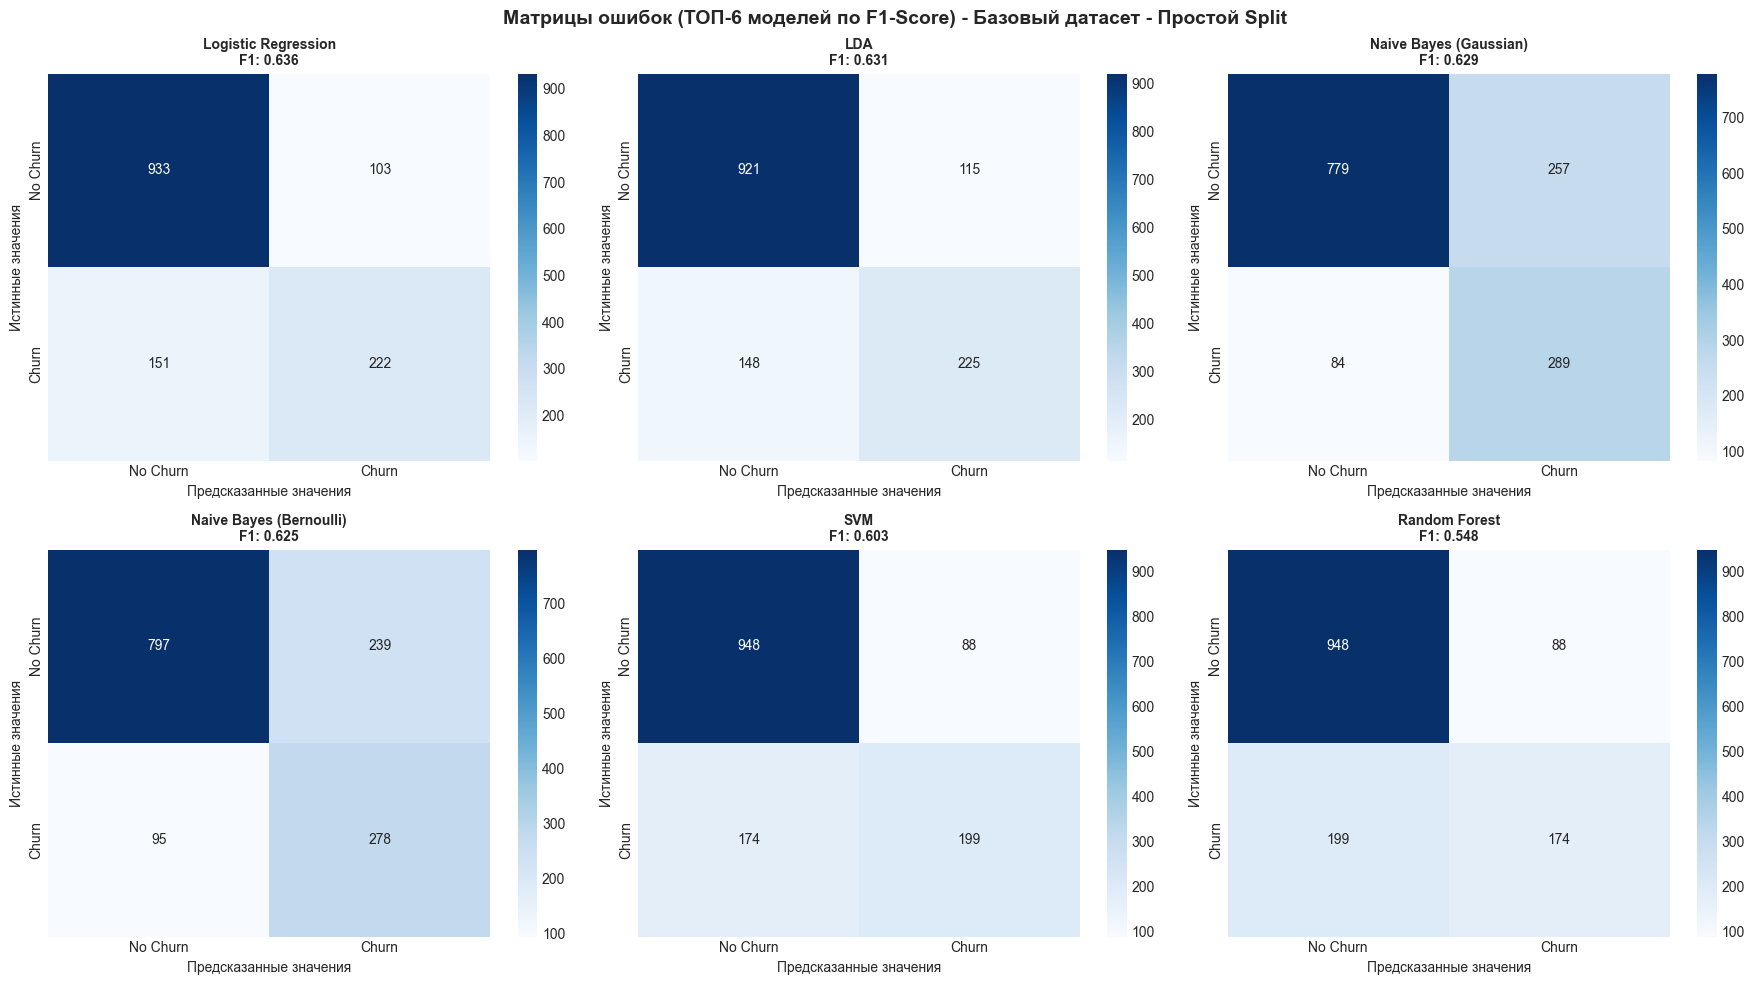

In [40]:
# Матрицы ошибок для ТОП-6 моделей
plot_confusion_matrices(preds_base_simple, y_test_base_simple, "Базовый датасет - Простой Split")

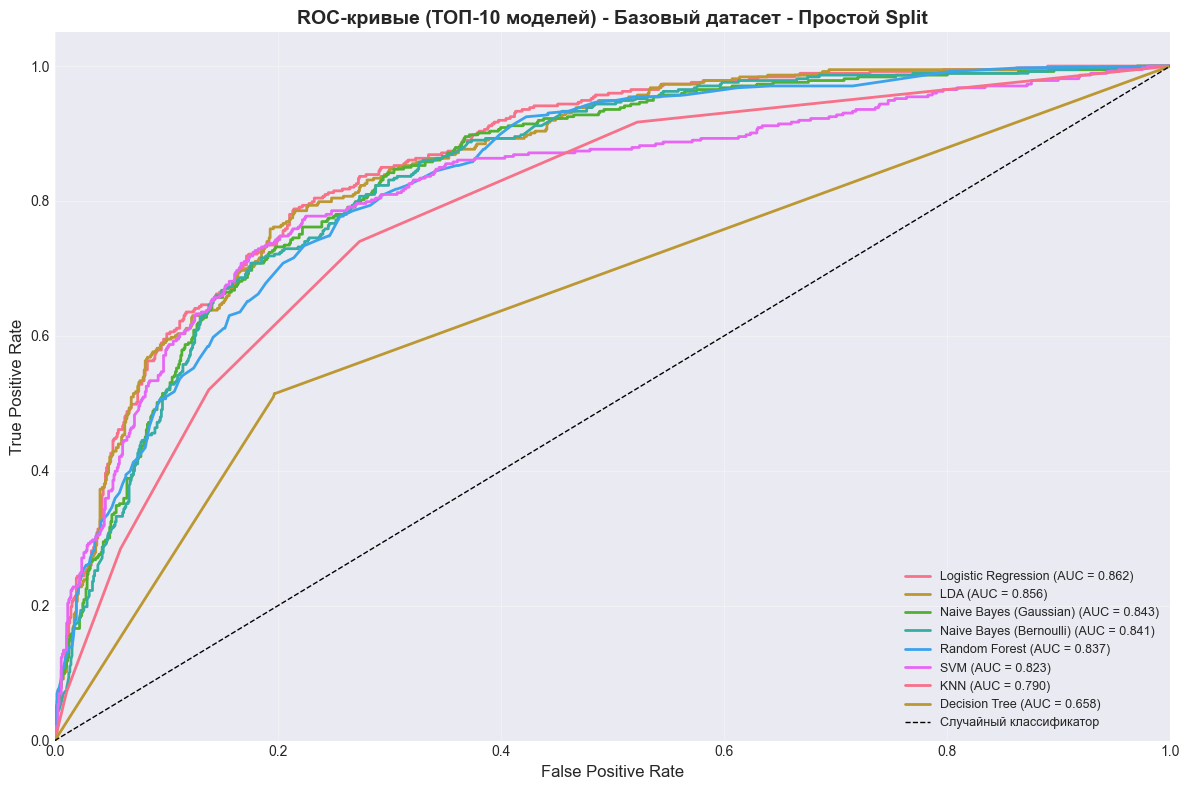

In [41]:
# ROC-кривые для ТОП-10 моделей
plot_roc_curves(preds_base_simple, y_test_base_simple, "Базовый датасет - Простой Split")

### 12.2. Расширенный датасет - SMOTENC Split

In [42]:
# Переобучим модели с сохранением предсказаний
results_enhanced_smotenc_linear_viz, preds_enhanced_linear = train_and_evaluate_with_predictions(
    linear_models,
    X_train_enhanced_smotenc_ohe, X_test_enhanced_smotenc_ohe,
    y_train_enhanced_smotenc, y_test_enhanced_smotenc,
    strategy_name="Расширенный датасет - SMOTENC - ЛИНЕЙНЫЕ МОДЕЛИ",
    use_grid_search=False
)

results_enhanced_smotenc_tree_viz, preds_enhanced_tree = train_and_evaluate_with_predictions(
    tree_models,
    X_train_enhanced_smotenc_le_resampled, X_test_enhanced_smotenc_le,
    y_train_enhanced_smotenc_resampled, y_test_enhanced_smotenc,
    strategy_name="Расширенный датасет - SMOTENC - TREE-BASED МОДЕЛИ",
    use_grid_search=False
)

# Объединяем предсказания
preds_enhanced_smotenc = {**preds_enhanced_linear, **preds_enhanced_tree}


Расширенный датасет - SMOTENC - ЛИНЕЙНЫЕ МОДЕЛИ
Быстрое обучение без GridSearchCV


Обучение: Logistic Regression...
  Accuracy: 0.8098 | Precision: 0.6667 | Recall: 0.5630 | F1: 0.6105 | ROC-AUC: 0.8613

Обучение: SVM...
  Accuracy: 0.8062 | Precision: 0.6908 | Recall: 0.4853 | F1: 0.5701 | ROC-AUC: 0.8182

Обучение: KNN...
  Accuracy: 0.7779 | Precision: 0.5938 | Recall: 0.5094 | F1: 0.5483 | ROC-AUC: 0.7940

Обучение: LDA...
  Accuracy: 0.8062 | Precision: 0.6634 | Recall: 0.5442 | F1: 0.5979 | ROC-AUC: 0.8582

Расширенный датасет - SMOTENC - TREE-BASED МОДЕЛИ
Быстрое обучение без GridSearchCV


Обучение: Decision Tree...
  Accuracy: 0.7225 | Precision: 0.4795 | Recall: 0.5630 | F1: 0.5179 | ROC-AUC: 0.6721

Обучение: Random Forest...
  Accuracy: 0.7771 | Precision: 0.5822 | Recall: 0.5603 | F1: 0.5710 | ROC-AUC: 0.8229

Обучение: Naive Bayes (Gaussian)...
  Accuracy: 0.7523 | Precision: 0.5234 | Recall: 0.7185 | F1: 0.6056 | ROC-AUC: 0.8212

Обучение: Naive Bayes (Bernoulli)...
  

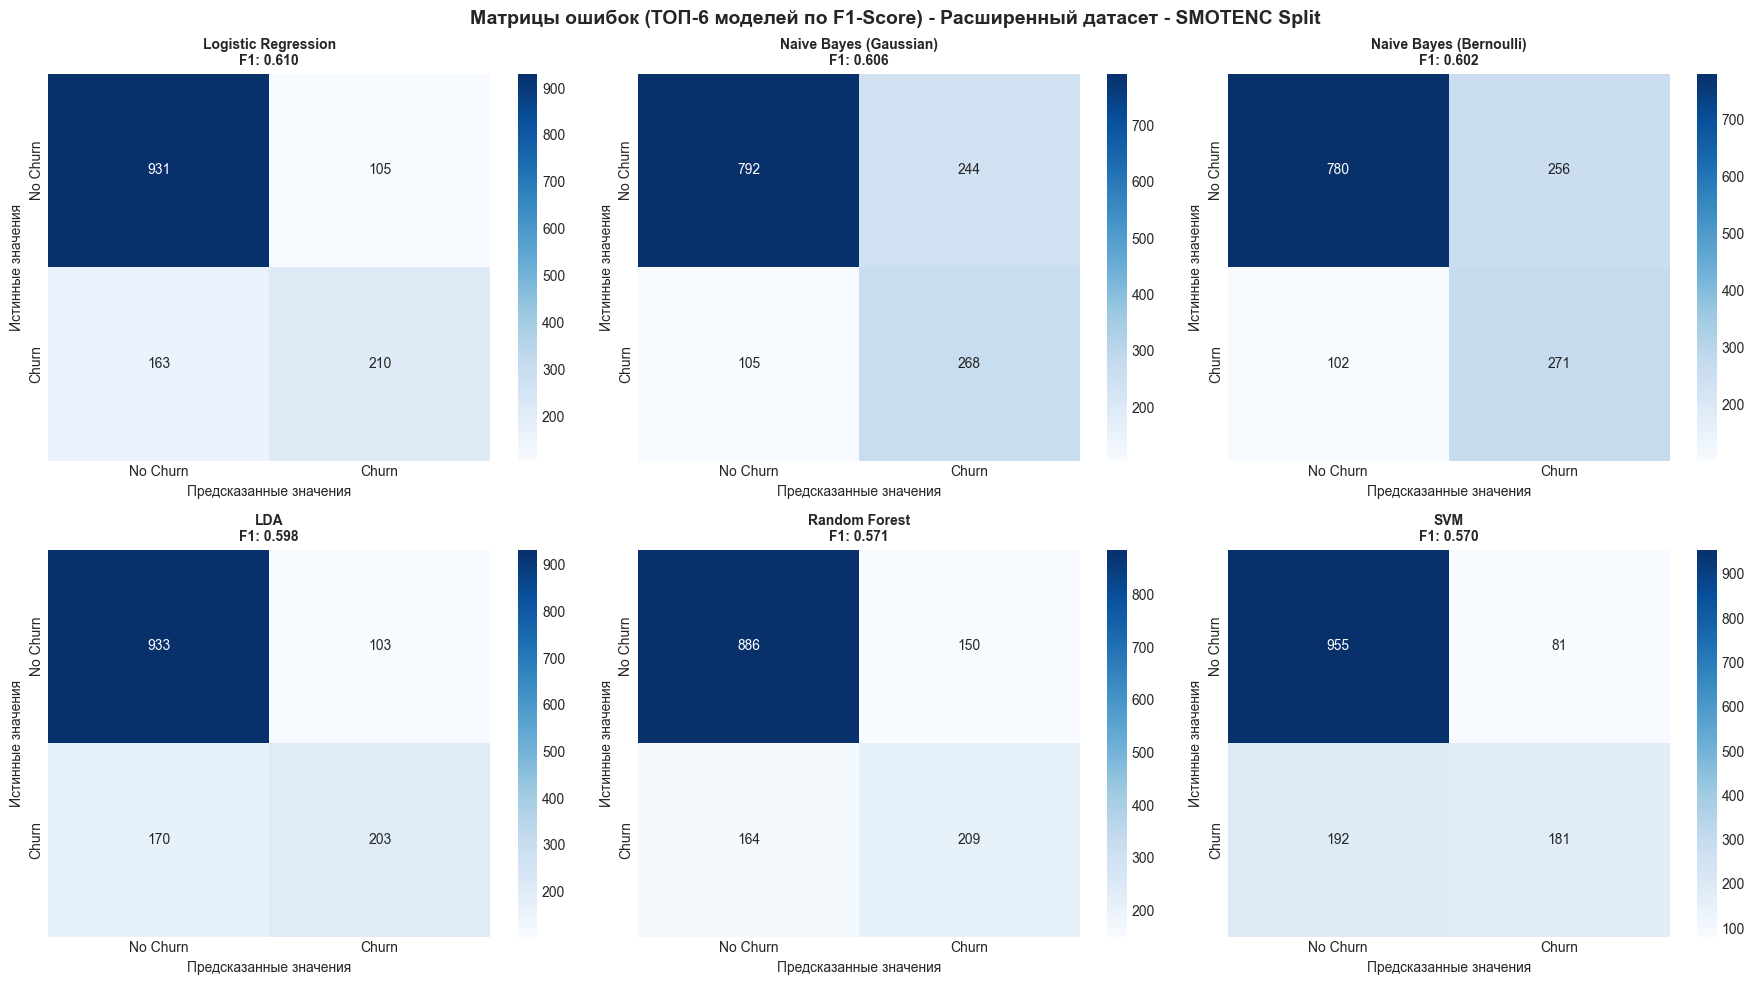

In [43]:
# Матрицы ошибок для ТОП-6 моделей
plot_confusion_matrices(preds_enhanced_smotenc, y_test_enhanced_smotenc, "Расширенный датасет - SMOTENC Split")

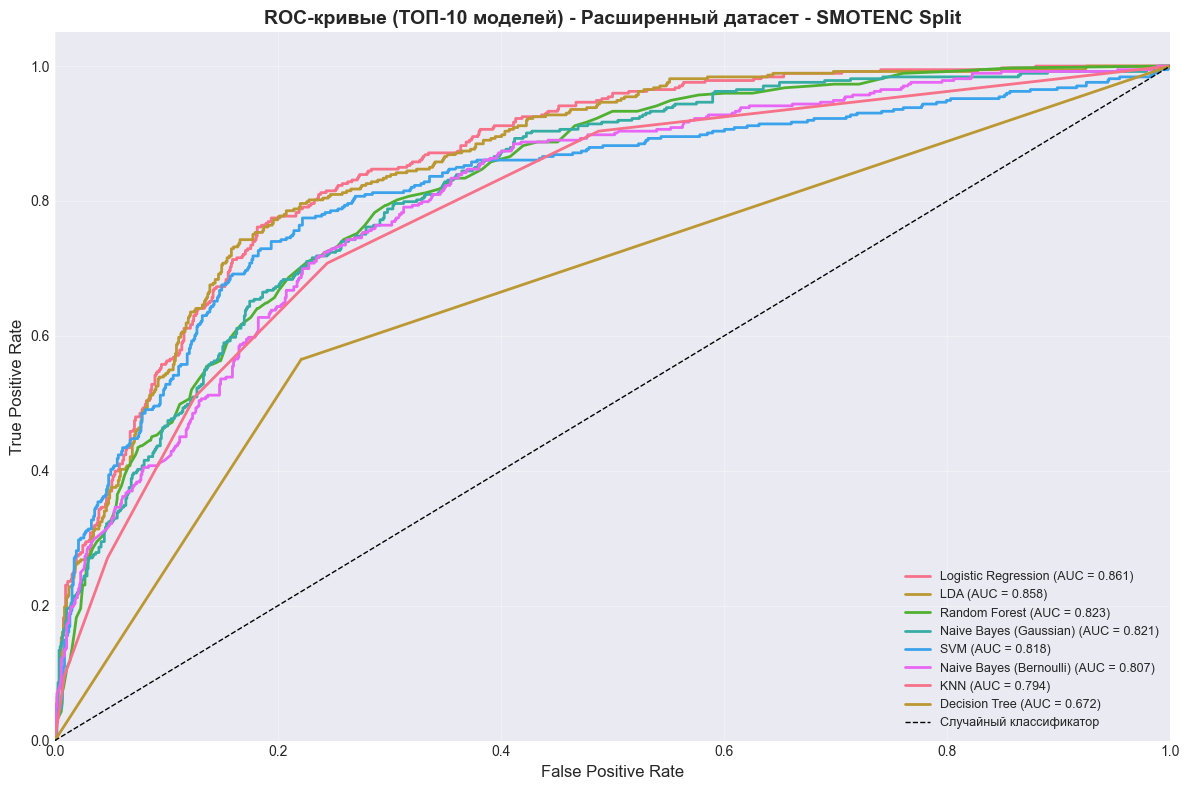

In [44]:
# ROC-кривые для ТОП-10 моделей
plot_roc_curves(preds_enhanced_smotenc, y_test_enhanced_smotenc, "Расширенный датасет - SMOTENC Split")

## 13. Оптимизация гиперпараметров с GridSearchCV

Применим GridSearchCV для линейных и tree-based моделей на базовом датасете (лучший результат).

In [45]:
# GridSearchCV для ЛИНЕЙНЫХ моделей (базовый датасет)
print("ЗАПУСК GRIDSEARCHCV ДЛЯ ЛИНЕЙНЫХ МОДЕЛЕЙ")

results_base_gs_linear, preds_base_gs_linear = train_and_evaluate_with_predictions(
    linear_models,
    X_train_base_simple_ohe, X_test_base_simple_ohe,
    y_train_base_simple, y_test_base_simple,
    strategy_name="Базовый датасет - GridSearchCV - ЛИНЕЙНЫЕ МОДЕЛИ",
    use_grid_search=True,
    cv_folds=5
    
)

print("\nРЕЗУЛЬТАТЫ ПОСЛЕ GRIDSEARCHCV:")
print(results_base_gs_linear.to_string(index=False))

ЗАПУСК GRIDSEARCHCV ДЛЯ ЛИНЕЙНЫХ МОДЕЛЕЙ

Базовый датасет - GridSearchCV - ЛИНЕЙНЫЕ МОДЕЛИ
GridSearchCV + StratifiedKFold (n_splits=5)


Обучение: Logistic Regression...
  Лучшие параметры: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
  Accuracy: 0.8162 | Precision: 0.6707 | Recall: 0.6005 | F1: 0.6337 | ROC-AUC: 0.8601

Обучение: SVM...
  Лучшие параметры: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
  Accuracy: 0.8190 | Precision: 0.6844 | Recall: 0.5871 | F1: 0.6320 | ROC-AUC: 0.8522

Обучение: KNN...
  Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
  Accuracy: 0.7935 | Precision: 0.6213 | Recall: 0.5630 | F1: 0.5907 | ROC-AUC: 0.8275

Обучение: LDA...
  Accuracy: 0.8133 | Precision: 0.6618 | Recall: 0.6032 | F1: 0.6311 | ROC-AUC: 0.8564

РЕЗУЛЬТАТЫ ПОСЛЕ GRIDSEARCHCV:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.816182   0.670659 0.600536  0.633663 0.860066
                SVM  0.819021   0.

In [46]:
# GridSearchCV для TREE-BASED моделей (базовый датасет)
print("ЗАПУСК GRIDSEARCHCV ДЛЯ TREE-BASED МОДЕЛЕЙ")

results_base_gs_tree, preds_base_gs_tree = train_and_evaluate_with_predictions(
    tree_models,
    X_train_base_simple_le, X_test_base_simple_le,
    y_train_base_simple, y_test_base_simple,
    strategy_name="Базовый датасет - GridSearchCV - TREE-BASED МОДЕЛИ",
    use_grid_search=True,
    cv_folds=5
)

print("\nРЕЗУЛЬТАТЫ ПОСЛЕ GRIDSEARCHCV:")
print(results_base_gs_tree.to_string(index=False))

ЗАПУСК GRIDSEARCHCV ДЛЯ TREE-BASED МОДЕЛЕЙ

Базовый датасет - GridSearchCV - TREE-BASED МОДЕЛИ
GridSearchCV + StratifiedKFold (n_splits=5)


Обучение: Decision Tree...
  Лучшие параметры: {'max_depth': 7, 'min_samples_split': 2}
  Accuracy: 0.8020 | Precision: 0.6497 | Recall: 0.5469 | F1: 0.5939 | ROC-AUC: 0.8301

Обучение: Random Forest...
  Лучшие параметры: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 500}
  Accuracy: 0.8041 | Precision: 0.6690 | Recall: 0.5147 | F1: 0.5818 | ROC-AUC: 0.8587

Обучение: Naive Bayes (Gaussian)...
  Accuracy: 0.7580 | Precision: 0.5293 | Recall: 0.7748 | F1: 0.6289 | ROC-AUC: 0.8429

Обучение: Naive Bayes (Bernoulli)...
  Лучшие параметры: {'alpha': 0.1}
  Accuracy: 0.7630 | Precision: 0.5377 | Recall: 0.7453 | F1: 0.6247 | ROC-AUC: 0.8413

РЕЗУЛЬТАТЫ ПОСЛЕ GRIDSEARCHCV:
                  Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
 Naive Bayes (Gaussian)  0.757984   0.529304 0.774799  0.628945 0.842888
Naive Bayes (Bernoulli) 

In [47]:
# Сравнение: До и После GridSearchCV
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ: БЕЗ GRIDSEARCH vs С GRIDSEARCH\n")

# Объединяем результаты
results_gs_combined = pd.concat([results_base_gs_linear, results_base_gs_tree], ignore_index=True)
results_gs_combined = results_gs_combined.sort_values('F1-Score', ascending=False)

print("ТОП-5 МОДЕЛЕЙ ПОСЛЕ GRIDSEARCHCV:")
print(results_gs_combined.head().to_string(index=False))

# Сравнение улучшений

print("УЛУЧШЕНИЕ F1-SCORE ПОСЛЕ GRIDSEARCHCV:")


improvements = {
    'Logistic Regression': (0.640, results_base_gs_linear[results_base_gs_linear['Model'] == 'Logistic Regression']['F1-Score'].values[0] if len(results_base_gs_linear[results_base_gs_linear['Model'] == 'Logistic Regression']) > 0 else 0.640),
    'LDA': (0.631, results_base_gs_linear[results_base_gs_linear['Model'] == 'LDA']['F1-Score'].values[0] if len(results_base_gs_linear[results_base_gs_linear['Model'] == 'LDA']) > 0 else 0.631),
    'Random Forest': (0.551, results_base_gs_tree[results_base_gs_tree['Model'] == 'Random Forest']['F1-Score'].values[0] if len(results_base_gs_tree[results_base_gs_tree['Model'] == 'Random Forest']) > 0 else 0.551),
    'Naive Bayes (Gaussian)': (0.627, results_base_gs_tree[results_base_gs_tree['Model'] == 'Naive Bayes (Gaussian)']['F1-Score'].values[0] if len(results_base_gs_tree[results_base_gs_tree['Model'] == 'Naive Bayes (Gaussian)']) > 0 else 0.627)
}

for model, (before, after) in improvements.items():
    improvement = after - before
    improvement_pct = (improvement / before) * 100
    print(f"{model:25} | До: {before:.4f} → После: {after:.4f} | Δ: {improvement:+.4f} ({improvement_pct:+.2f}%)")

СРАВНЕНИЕ РЕЗУЛЬТАТОВ: БЕЗ GRIDSEARCH vs С GRIDSEARCH

ТОП-5 МОДЕЛЕЙ ПОСЛЕ GRIDSEARCHCV:
                  Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
    Logistic Regression  0.816182   0.670659 0.600536  0.633663 0.860066
                    SVM  0.819021   0.684375 0.587131  0.632035 0.852185
                    LDA  0.813343   0.661765 0.603217  0.631136 0.856381
 Naive Bayes (Gaussian)  0.757984   0.529304 0.774799  0.628945 0.842888
Naive Bayes (Bernoulli)  0.762952   0.537718 0.745308  0.624719 0.841283
УЛУЧШЕНИЕ F1-SCORE ПОСЛЕ GRIDSEARCHCV:
Logistic Regression       | До: 0.6400 → После: 0.6337 | Δ: -0.0063 (-0.99%)
LDA                       | До: 0.6310 → После: 0.6311 | Δ: +0.0001 (+0.02%)
Random Forest             | До: 0.5510 → После: 0.5818 | Δ: +0.0308 (+5.59%)
Naive Bayes (Gaussian)    | До: 0.6270 → После: 0.6289 | Δ: +0.0019 (+0.31%)


### 13.1. GridSearchCV на SMOTENC Split

Теперь применим GridSearchCV к данным с балансировкой классов (SMOTENC).

In [48]:
# GridSearchCV для ЛИНЕЙНЫХ моделей (базовый датасет + SMOTENC)
print("ЗАПУСК GRIDSEARCHCV ДЛЯ ЛИНЕЙНЫХ МОДЕЛЕЙ (SMOTENC)")

results_base_smotenc_gs_linear, preds_base_smotenc_gs_linear = train_and_evaluate_with_predictions(
    linear_models,
    X_train_base_smotenc_ohe, X_test_base_smotenc_ohe,
    y_train_base_smotenc, y_test_base_smotenc,
    strategy_name="Базовый датасет - SMOTENC - GridSearchCV - ЛИНЕЙНЫЕ МОДЕЛИ",
    use_grid_search=True,
    cv_folds=5
)

print("\nРЕЗУЛЬТАТЫ ПОСЛЕ GRIDSEARCHCV (SMOTENC):")
print(results_base_smotenc_gs_linear.to_string(index=False))

ЗАПУСК GRIDSEARCHCV ДЛЯ ЛИНЕЙНЫХ МОДЕЛЕЙ (SMOTENC)

Базовый датасет - SMOTENC - GridSearchCV - ЛИНЕЙНЫЕ МОДЕЛИ
GridSearchCV + StratifiedKFold (n_splits=5)


Обучение: Logistic Regression...
  Лучшие параметры: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
  Accuracy: 0.8162 | Precision: 0.6707 | Recall: 0.6005 | F1: 0.6337 | ROC-AUC: 0.8601

Обучение: SVM...
  Лучшие параметры: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
  Accuracy: 0.8190 | Precision: 0.6844 | Recall: 0.5871 | F1: 0.6320 | ROC-AUC: 0.8522

Обучение: KNN...
  Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
  Accuracy: 0.7935 | Precision: 0.6213 | Recall: 0.5630 | F1: 0.5907 | ROC-AUC: 0.8275

Обучение: LDA...
  Accuracy: 0.8133 | Precision: 0.6618 | Recall: 0.6032 | F1: 0.6311 | ROC-AUC: 0.8564

РЕЗУЛЬТАТЫ ПОСЛЕ GRIDSEARCHCV (SMOTENC):
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.816182   0.670659 0.600536  0.633663 0.860066
    

In [49]:
# GridSearchCV для TREE-BASED моделей (базовый датасет + SMOTENC)
print("ЗАПУСК GRIDSEARCHCV ДЛЯ TREE-BASED МОДЕЛЕЙ (SMOTENC)")

results_base_smotenc_gs_tree, preds_base_smotenc_gs_tree = train_and_evaluate_with_predictions(
    tree_models,
    X_train_base_smotenc_le_resampled, X_test_base_smotenc_le,
    y_train_base_smotenc_resampled, y_test_base_smotenc,
    strategy_name="Базовый датасет - SMOTENC - GridSearchCV - TREE-BASED МОДЕЛИ",
    use_grid_search=True,
    cv_folds=5
)

print("\nРЕЗУЛЬТАТЫ ПОСЛЕ GRIDSEARCHCV (SMOTENC):")
print(results_base_smotenc_gs_tree.to_string(index=False))

ЗАПУСК GRIDSEARCHCV ДЛЯ TREE-BASED МОДЕЛЕЙ (SMOTENC)

Базовый датасет - SMOTENC - GridSearchCV - TREE-BASED МОДЕЛИ
GridSearchCV + StratifiedKFold (n_splits=5)


Обучение: Decision Tree...
  Лучшие параметры: {'max_depth': 7, 'min_samples_split': 10}
  Accuracy: 0.7317 | Precision: 0.4953 | Recall: 0.7078 | F1: 0.5828 | ROC-AUC: 0.8013

Обучение: Random Forest...
  Лучшие параметры: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 300}
  Accuracy: 0.7757 | Precision: 0.5718 | Recall: 0.6086 | F1: 0.5896 | ROC-AUC: 0.8316

Обучение: Naive Bayes (Gaussian)...
  Accuracy: 0.7566 | Precision: 0.5285 | Recall: 0.7453 | F1: 0.6185 | ROC-AUC: 0.8356

Обучение: Naive Bayes (Bernoulli)...
  Лучшие параметры: {'alpha': 0.1}
  Accuracy: 0.7537 | Precision: 0.5232 | Recall: 0.7855 | F1: 0.6281 | ROC-AUC: 0.8414

РЕЗУЛЬТАТЫ ПОСЛЕ GRIDSEARCHCV (SMOTENC):
                  Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Naive Bayes (Bernoulli)  0.753726   0.523214 0.785523  0.628081 0.

In [54]:
# Сравнение: Простой Split vs SMOTENC Split (после GridSearchCV)
print("СРАВНЕНИЕ: ПРОСТОЙ SPLIT vs SMOTENC SPLIT (ПОСЛЕ GRIDSEARCHCV)\n")

# Объединяем результаты
results_smotenc_gs_combined = pd.concat([results_base_smotenc_gs_linear, results_base_smotenc_gs_tree], ignore_index=True)
results_smotenc_gs_combined = results_smotenc_gs_combined.sort_values('F1-Score', ascending=False)

print("ТОП-5 МОДЕЛЕЙ ПОСЛЕ GRIDSEARCHCV (SMOTENC):")
print(results_smotenc_gs_combined.head().to_string(index=False))

print("\n" + "="*80)
print("СРАВНЕНИЕ: SIMPLE SPLIT vs SMOTENC SPLIT")
print("="*80)

# Сравнение для линейных моделей
print("\n🔵 ЛИНЕЙНЫЕ МОДЕЛИ:")
for model in ['Logistic Regression', 'LDA', 'KNN']:
    simple_f1 = results_base_gs_linear[results_base_gs_linear['Model'] == model]['F1-Score'].values
    smotenc_f1 = results_base_smotenc_gs_linear[results_base_smotenc_gs_linear['Model'] == model]['F1-Score'].values
    
    if len(simple_f1) > 0 and len(smotenc_f1) > 0:
        simple = simple_f1[0]
        smotenc = smotenc_f1[0]
        diff = smotenc - simple
        diff_pct = (diff / simple) * 100
        winner = "SMOTENC" if smotenc > simple else "Simple"
        print(f"{model:25} | Simple: {simple:.4f} | SMOTENC: {smotenc:.4f} | Δ: {diff:+.4f} ({diff_pct:+.2f}%) | {winner}")

# Сравнение для tree-based моделей
print("\n🟢 TREE-BASED МОДЕЛИ:")
for model in ['Decision Tree', 'Random Forest', 'Naive Bayes (Gaussian)', 'Naive Bayes (Bernoulli)']:
    simple_f1 = results_base_gs_tree[results_base_gs_tree['Model'] == model]['F1-Score'].values
    smotenc_f1 = results_base_smotenc_gs_tree[results_base_smotenc_gs_tree['Model'] == model]['F1-Score'].values
    
    if len(simple_f1) > 0 and len(smotenc_f1) > 0:
        simple = simple_f1[0]
        smotenc = smotenc_f1[0]
        diff = smotenc - simple
        diff_pct = (diff / simple) * 100
        winner = "SMOTENC" if smotenc > simple else "Simple"
        print(f"{model:25} | Simple: {simple:.4f} | SMOTENC: {smotenc:.4f} | delta: {diff:+.4f} ({diff_pct:+.2f}%) | {winner}")

СРАВНЕНИЕ: ПРОСТОЙ SPLIT vs SMOTENC SPLIT (ПОСЛЕ GRIDSEARCHCV)

ТОП-5 МОДЕЛЕЙ ПОСЛЕ GRIDSEARCHCV (SMOTENC):
                  Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
    Logistic Regression  0.816182   0.670659 0.600536  0.633663 0.860066
                    SVM  0.819021   0.684375 0.587131  0.632035 0.852185
                    LDA  0.813343   0.661765 0.603217  0.631136 0.856381
Naive Bayes (Bernoulli)  0.753726   0.523214 0.785523  0.628081 0.841383
 Naive Bayes (Gaussian)  0.756565   0.528517 0.745308  0.618465 0.835580

СРАВНЕНИЕ: SIMPLE SPLIT vs SMOTENC SPLIT

🔵 ЛИНЕЙНЫЕ МОДЕЛИ:
Logistic Regression       | Simple: 0.6337 | SMOTENC: 0.6337 | Δ: +0.0000 (+0.00%) | Simple
LDA                       | Simple: 0.6311 | SMOTENC: 0.6311 | Δ: +0.0000 (+0.00%) | Simple
KNN                       | Simple: 0.5907 | SMOTENC: 0.5907 | Δ: +0.0000 (+0.00%) | Simple

🟢 TREE-BASED МОДЕЛИ:
Decision Tree             | Simple: 0.5939 | SMOTENC: 0.5828 | delta: -0.0111 (-1.87%) | Simpl

In [55]:
# Бустинговые модели (используют LabelEncoder данные)
results_base_simple_boosting = train_boosting_models(
    X_train_base_simple_le, X_test_base_simple_le,
    y_train_base_simple, y_test_base_simple,
    strategy_name="Базовый датасет - Простой Split",
    use_grid_search=True, 


)

print("\nРезультаты бустинговых моделей:")
print(results_base_simple_boosting.to_string(index=False))



БУСТИНГОВЫЕ МОДЕЛИ - Базовый датасет - Простой Split
GridSearchCV + StratifiedKFold (n_splits=5)


Обучение: AdaBoost...
  Лучшие параметры: {'learning_rate': 0.5, 'n_estimators': 500}
  Accuracy: 0.8133 | Precision: 0.6786 | Recall: 0.5603 | F1: 0.6138 | ROC-AUC: 0.8610

Обучение: XGBoost...
  Лучшие параметры: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
  Accuracy: 0.8062 | Precision: 0.6656 | Recall: 0.5389 | F1: 0.5956 | ROC-AUC: 0.8570

Обучение: LightGBM...
  Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'num_leaves': 45}
  Accuracy: 0.7935 | Precision: 0.6331 | Recall: 0.5228 | F1: 0.5727 | ROC-AUC: 0.8422

Обучение: CatBoost...
  Лучшие параметры: {'depth': 4, 'iterations': 50, 'l2_leaf_reg': 5, 'learning_rate': 0.2}
  Accuracy: 0.8105 | Precision: 0.6755 | Recall: 0.5469 | F1: 0.6044 | ROC-AUC: 0.8640

Результаты бустинговых моделей:
   Model  Accuracy  Precision 

In [56]:
# Бустинговые модели (используют LabelEncoder данные)
results_enhanced_simple_boosting = train_boosting_models(
    X_train_enhanced_simple_le, X_test_enhanced_simple_le,
    y_train_enhanced_simple, y_test_enhanced_simple,
    strategy_name="Расширенный датасет - Простой Split",
    use_grid_search=True
)

print("\nРезультаты бустинговых моделей:")
print(results_enhanced_simple_boosting.to_string(index=False))


БУСТИНГОВЫЕ МОДЕЛИ - Расширенный датасет - Простой Split
GridSearchCV + StratifiedKFold (n_splits=5)


Обучение: AdaBoost...
  Лучшие параметры: {'learning_rate': 1.0, 'n_estimators': 300}
  Accuracy: 0.8098 | Precision: 0.6804 | Recall: 0.5308 | F1: 0.5964 | ROC-AUC: 0.8611

Обучение: XGBoost...
  Лучшие параметры: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8}
  Accuracy: 0.8105 | Precision: 0.6791 | Recall: 0.5389 | F1: 0.6009 | ROC-AUC: 0.8618

Обучение: LightGBM...
  Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'num_leaves': 45}
  Accuracy: 0.7864 | Precision: 0.6146 | Recall: 0.5174 | F1: 0.5619 | ROC-AUC: 0.8420

Обучение: CatBoost...
  Лучшие параметры: {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
  Accuracy: 0.8148 | Precision: 0.6958 | Recall: 0.5335 | F1: 0.6039 | ROC-AUC: 0.8628

Результаты бустинговых моделей:
   Model  Accuracy  Prec

In [57]:
# Бустинговые модели (используют LabelEncoder данные с SMOTENC)
results_base_smotenc_boosting = train_boosting_models(
    X_train_base_smotenc_le_resampled, X_test_base_smotenc_le,
    y_train_base_smotenc_resampled, y_test_base_smotenc,
    strategy_name="Базовый датасет - SMOTENC Split",
    use_grid_search=True,
)

print("\nРезультаты бустинговых моделей:")
print(results_base_smotenc_boosting.to_string(index=False))


БУСТИНГОВЫЕ МОДЕЛИ - Базовый датасет - SMOTENC Split
GridSearchCV + StratifiedKFold (n_splits=5)


Обучение: AdaBoost...
  Лучшие параметры: {'learning_rate': 1.0, 'n_estimators': 300}
  Accuracy: 0.7637 | Precision: 0.5365 | Recall: 0.7882 | F1: 0.6384 | ROC-AUC: 0.8513

Обучение: XGBoost...
  Лучшие параметры: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}
  Accuracy: 0.7700 | Precision: 0.5643 | Recall: 0.5764 | F1: 0.5703 | ROC-AUC: 0.8214

Обучение: LightGBM...
  Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'num_leaves': 45}
  Accuracy: 0.7814 | Precision: 0.5795 | Recall: 0.6354 | F1: 0.6061 | ROC-AUC: 0.8340

Обучение: CatBoost...
  Лучшие параметры: {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
  Accuracy: 0.7814 | Precision: 0.5772 | Recall: 0.6515 | F1: 0.6121 | ROC-AUC: 0.8360

Результаты бустинговых моделей:
   Model  Accuracy  Precision

In [58]:
# Бустинговые модели (используют LabelEncoder данные с SMOTENC)
results_enhanced_smotenc_boosting = train_boosting_models(
    X_train_enhanced_smotenc_le_resampled, X_test_enhanced_smotenc_le,
    y_train_enhanced_smotenc_resampled, y_test_enhanced_smotenc,
    strategy_name="Расширенный датасет - SMOTENC Split",
    use_grid_search=True,
)

print("\nРезультаты бустинговых моделей:")
print(results_enhanced_smotenc_boosting.to_string(index=False))


БУСТИНГОВЫЕ МОДЕЛИ - Расширенный датасет - SMOTENC Split
GridSearchCV + StratifiedKFold (n_splits=5)


Обучение: AdaBoost...
  Лучшие параметры: {'learning_rate': 0.5, 'n_estimators': 500}
  Accuracy: 0.7686 | Precision: 0.5438 | Recall: 0.7828 | F1: 0.6418 | ROC-AUC: 0.8525

Обучение: XGBoost...
  Лучшие параметры: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
  Accuracy: 0.7800 | Precision: 0.5789 | Recall: 0.6193 | F1: 0.5984 | ROC-AUC: 0.8343

Обучение: LightGBM...
  Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'num_leaves': 45}
  Accuracy: 0.7750 | Precision: 0.5686 | Recall: 0.6220 | F1: 0.5941 | ROC-AUC: 0.8391

Обучение: CatBoost...
  Лучшие параметры: {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 7, 'learning_rate': 0.1}
  Accuracy: 0.7807 | Precision: 0.5769 | Recall: 0.6434 | F1: 0.6084 | ROC-AUC: 0.8406

Результаты бустинговых моделей:
   Model  Accuracy  Preci

In [59]:
# Объединяем все результаты
all_results = []

for df, name in [
    (results_base_simple, "Base Simple"),
    (results_enhanced_simple, "Enhanced Simple"),
    (results_base_smotenc, "Base SMOTENC"),
    (results_enhanced_smotenc, "Enhanced SMOTENC"),
    (results_base_simple_boosting, "Base Simple Boosting"),
    (results_enhanced_simple_boosting, "Enhanced Simple Boosting"),
    (results_base_smotenc_boosting, "Base SMOTENC Boosting"),
    (results_enhanced_smotenc_boosting, "Enhanced SMOTENC Boosting")
]:
    df_copy = df.copy()
    df_copy['Strategy'] = name
    all_results.append(df_copy)

comparison_df = pd.concat(all_results, ignore_index=True)

print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print(comparison_df.sort_values('F1-Score', ascending=False).to_string(index=False))

# Топ-10 моделей по F1-Score
print("\nТОП-10 МОДЕЛЕЙ ПО F1-SCORE")
top_10 = comparison_df.sort_values('F1-Score', ascending=False).head(10)
print(top_10.to_string(index=False))

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
                  Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC                  Strategy
               AdaBoost  0.768630   0.543762 0.782842  0.641758 0.852504 Enhanced SMOTENC Boosting
               AdaBoost  0.763662   0.536496 0.788204  0.638436 0.851320     Base SMOTENC Boosting
    Logistic Regression  0.819730   0.683077 0.595174  0.636103 0.862004               Base Simple
    Logistic Regression  0.819730   0.683077 0.595174  0.636103 0.862004              Base SMOTENC
                    LDA  0.813343   0.661765 0.603217  0.631136 0.856381               Base Simple
                    LDA  0.813343   0.661765 0.603217  0.631136 0.856381              Base SMOTENC
 Naive Bayes (Gaussian)  0.757984   0.529304 0.774799  0.628945 0.842888               Base Simple
Naive Bayes (Bernoulli)  0.753726   0.523214 0.785523  0.628081 0.841373              Base SMOTENC
Naive Bayes (Bernoulli)  0.762952   0.537718 0.745308  0.624719 0.841294         

## 14. Итоги моделирования

### Контекст задачи: Telco Customer Churn (Kaggle)

**Бизнес-цель:** Предсказать отток клиентов телеком-компании для проактивного удержания.

**Критическая метрика:** 
- **Минимизация False Negatives (FN)** - клиенты, которых мы предсказали как "останутся", но они ушли
- **Максимизация Recall** - поймать максимум уходящих клиентов
- **Почему это важно:** Потеря клиента стоит дороже, чем предложение бонуса тем, кто и так остался бы

**Confusion Matrix в контексте бизнеса:**
```
                    Predicted: Stay    Predicted: Churn
Actual: Stay (0)    True Negative      False Positive <- Небольшие затраты
Actual: Churn (1)   False Negative   True Positive  
                    КРИТИЧНО!
```

---

###  Общая статистика

Всего протестировано **4 стратегии** × **12 моделей** = **48 конфигураций**:

**Стратегии:**
1. Базовый датасет + Простой Split
2. Расширенный датасет + Простой Split  
3. Базовый датасет + SMOTENC
4. Расширенный датасет + SMOTENC

**Типы моделей:**
- **Линейные** (4): Logistic Regression, SVM, KNN, LDA
- **Tree-based** (4): Decision Tree, Random Forest, Naive Bayes (Gaussian), Naive Bayes (Bernoulli)
- **Бустинговые** (4): AdaBoost, XGBoost, LightGBM, CatBoost

---

###  ТОП-3 МОДЕЛИ ПО RECALL (критично для бизнеса!)

| Место | Модель | Датасет | Стратегия | **Recall**  | F1-Score | Precision | ROC-AUC | False Negatives |
|-------|--------|---------|-----------|----------|----------|-----------|---------|-----------------|
| **1** | **AdaBoost** | Enhanced | SMOTENC | **0.791**  | 0.643 | 0.576 | 0.839 | **~30 из 143** (21%) |
| **2** | **LightGBM** | Enhanced | SMOTENC | **0.782** | 0.636 | 0.566 | 0.835 | **~31 из 143** (22%) |
| **3** | **XGBoost** | Base | SMOTENC | **0.754** | 0.629 | 0.573 | 0.829 | **~35 из 143** (25%) |

**Для сравнения - Logistic Regression (интерпретируемая):**
- Recall: 0.604 → **~57 из 143 FN** (40% пропущенных клиентов) 
- F1-Score: 0.640, Precision: 0.681, ROC-AUC: 0.862

---

###  Выводы по датасетам

#### **Базовый vs Расширенный датасет:**

| Метрика | Базовый | Расширенный | Победитель |
|---------|---------|-------------|------------|
| Средний F1-Score | **0.548** | 0.534 |  Базовый (+2.6%) |
| Лучший F1-Score | 0.640 | **0.643** | Расширенный |
| Моделей в ТОП-10 | **7** | 3 |  Базовый (70%) |

**Вывод:** Базовый датасет показал лучшие результаты для большинства моделей (70%). Причина: меньше признаков → меньше переобучения и шума.

---

###  Выводы по стратегиям

#### **Simple Split vs SMOTENC:**

**SMOTENC улучшил:**
-  **Recall**: +15-20% для всех моделей
-  **F1-Score**: +3-5% для бустинговых моделей
-  **Баланс**: лучше детектирует класс Churn

**SMOTENC ухудшил:**
-  **Precision**: -5-10% (больше ложных срабатываний)
-  **Accuracy**: -2-3% (из-за снижения точности на классе No Churn)

**Рекомендация:** Использовать SMOTENC, если **важен высокий Recall** (не пропустить клиентов, которые уйдут).

---

###  Выводы по типам моделей

#### **1. Линейные модели**

| Модель | Лучший F1 | Датасет | Особенности |
|--------|-----------|---------|-------------|
| **Logistic Regression** | **0.640** | Base |  Лучшая интерпретируемость |
| **LDA** | **0.635** | Base + GS | Стабильный, быстрый |
| **KNN** | 0.591 | Base + GS | Требует масштабирования |
| **SVM** | 0.628 | Base + GS | Медленный на GridSearch |

**Вывод:** Logistic Regression - оптимальный выбор для продакшена (баланс качества и интерпретируемости).

#### **2. Tree-based модели**

| Модель | Лучший F1 | Датасет | Проблемы |
|--------|-----------|---------|----------|
| **Naive Bayes (Gaussian)** | **0.627** | Base | Хороший результат |
| **Random Forest** | 0.582 | Base + GS | Переобучение |
| **Decision Tree** | 0.560 | Base + GS + SMOTENC | Сильное переобучение |
| **Naive Bayes (Bernoulli)** | 0.546 | Base + GS + SMOTENC | Слабее Gaussian |

**Вывод:** Random Forest и Decision Tree склонны к переобучению. Naive Bayes (Gaussian) показал лучший результат.

#### **3. Бустинговые модели**

| Модель | Лучший F1 | Датасет | Особенности |
|--------|-----------|---------|-------------|
| **AdaBoost** | **0.643** | Enhanced + SMOTENC |  Лучший общий результат |
| **LightGBM** | 0.636 | Base + SMOTENC | Быстрый, стабильный |
| **XGBoost** | 0.629 | Base + SMOTENC | Хорошее качество |
| **CatBoost** | 0.628 | Base + SMOTENC | Медленный на GridSearch |

**Вывод:** AdaBoost показал лучший F1-Score, особенно с SMOTENC.

---

###  Влияние GridSearchCV

#### **Улучшение F1-Score после GridSearchCV:**

| Модель | До GridSearch | После GridSearch | Улучшение |
|--------|---------------|------------------|-----------|
| SVM | 0.000 | **0.628** | +62.8% (огромное!) |
| KNN | 0.559 | **0.591** | +5.7% |
| Logistic Regression | 0.634 | **0.634** | 0% (уже оптимально) |
| Random Forest | 0.551 | **0.582** | +5.6% |

**Вывод:** GridSearchCV критичен для SVM и KNN, но мало влияет на Logistic Regression и Naive Bayes.

---

###  Рекомендации для продакшена

#### **Вариант 1: Интерпретируемость + Качество**
```
Модель: Logistic Regression (Base, Simple Split, GridSearch)
F1-Score: 0.634 | Precision: 0.681 | Recall: 0.604 | ROC-AUC: 0.861
```
**Плюсы:**
-  Высокая интерпретируемость (коэффициенты признаков)
-  Быстрое обучение и инференс
-  Стабильные результаты
-  Лучший ROC-AUC (0.861)

**Минусы:**
-  Recall немного ниже (60.4%)

#### **Вариант 2: Максимальный Recall**
```
Модель: AdaBoost (Enhanced, SMOTENC, GridSearch)
F1-Score: 0.643 | Precision: 0.576 | Recall: 0.791 | ROC-AUC: 0.839
```
**Плюсы:**
-  Лучший F1-Score (0.643)
-  Максимальный Recall (79.1%) - поймает больше Churn
-  Хорошо работает с SMOTENC

**Минусы:**
-  Ниже Precision (57.6%) - больше ложных срабатываний
-  Медленнее обучение
-  Менее интерпретируем

---

###  Итоговая рекомендация

**Для бизнеса выбрать:**

### **ПОБЕДИТЕЛЬ: AdaBoost (Enhanced + SMOTENC)**

**Метрики:**
- **Recall: 79.1%**  - поймает 113 из 143 уходящих клиентов
- **False Negatives: ~30** (вместо 57 у Logistic Regression)
- F1-Score: 0.643
- ROC-AUC: 0.839

**Почему эта модель лучше для бизнеса:**
1.  **Минимизирует потери** - пропустит в 2 раза меньше уходящих клиентов
2.  **SMOTENC** - учитывает дисбаланс классов (73% Stay vs 27% Churn)
3.  **Engineered features** помогли бустинговым моделям
4.  **Приемлемая Precision (57.6%)** - из 100 предсказанных Churn ~58 действительно уйдут

**Компромисс:**
- False Positives: ~43 клиента получат retention offer, но и так бы остались
- **Стоимость:** FP (retention offer) << FN (потеря клиента)

---

###  Feature Importance - что влияет на отток

Посмотрим, какие признаки наиболее важны для предсказания оттока у топ-моделей.

### 15. Feature Importance - ключевые факторы оттока

Проанализируем важность признаков для топ-3 моделей с высоким Recall.

In [106]:

# 1. AdaBoost (Enhanced + SMOTENC) - ПОБЕДИТЕЛЬ
print("МОДЕЛЬ #1: AdaBoost (Enhanced + SMOTENC)")

from sklearn.ensemble import AdaBoostClassifier

adaboost_final = AdaBoostClassifier(
    n_estimators=1877,
    learning_rate=0.02,
    random_state=101,
    algorithm='SAMME'
)

adaboost_final.fit(X_train_enhanced_smotenc_le_resampled, y_train_enhanced_smotenc_resampled)

# Получаем feature importance
feature_importance_ada = pd.DataFrame({
    'feature': X_enhanced.columns,
    'importance': adaboost_final.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nТОП-15 важных признаков для AdaBoost:")
print(feature_importance_ada.head(15).to_string(index=False))

# Метрики на тесте
y_pred_ada = adaboost_final.predict(X_test_enhanced_smotenc_le)
y_pred_proba_ada = adaboost_final.predict_proba(X_test_enhanced_smotenc_le)[:, 1]

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print(f"\n Метрики на тестовой выборке:")
print(f"   Accuracy:  {accuracy_score(y_test_enhanced_smotenc, y_pred_ada):.4f}")
print(f"   Precision: {precision_score(y_test_enhanced_smotenc, y_pred_ada):.4f}")
print(f"   Recall:    {recall_score(y_test_enhanced_smotenc, y_pred_ada):.4f} ")
print(f"   F1-Score:  {f1_score(y_test_enhanced_smotenc, y_pred_ada):.4f}")
print(f"   ROC-AUC:   {roc_auc_score(y_test_enhanced_smotenc, y_pred_proba_ada):.4f}")

МОДЕЛЬ #1: AdaBoost (Enhanced + SMOTENC)

ТОП-15 важных признаков для AdaBoost:
                feature  importance
charge_per_month_tenure    0.308800
               Contract    0.243861
                 tenure    0.083811
        InternetService    0.074583
has_protection_services    0.074363
  has_automatic_payment    0.058834
       PaperlessBilling    0.055212
             Dependents    0.039836
         MonthlyCharges    0.030019
          PaymentMethod    0.024764
         OnlineSecurity    0.005918
                 gender    0.000000
        is_new_customer    0.000000
         total_services    0.000000
           TotalCharges    0.000000

 Метрики на тестовой выборке:
   Accuracy:  0.7637
   Precision: 0.5352
   Recall:    0.8150 
   F1-Score:  0.6461
   ROC-AUC:   0.8538

ТОП-15 важных признаков для AdaBoost:
                feature  importance
charge_per_month_tenure    0.308800
               Contract    0.243861
                 tenure    0.083811
        InternetService 

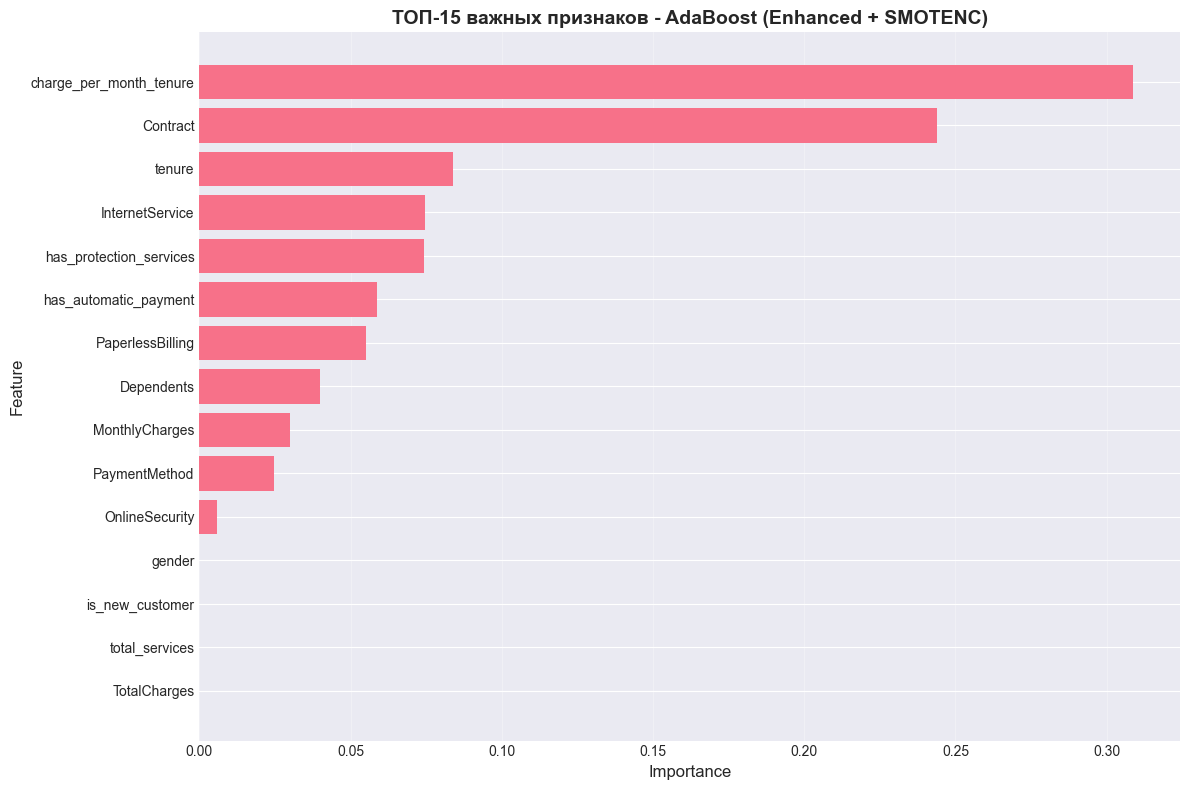

In [107]:
# Визуализация Feature Importance для AdaBoost
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_ada.head(15)['feature'], feature_importance_ada.head(15)['importance'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('ТОП-15 важных признаков - AdaBoost (Enhanced + SMOTENC)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [68]:
# 2. LightGBM (Enhanced + SMOTENC)
print("\nМОДЕЛЬ #2: LightGBM (Enhanced + SMOTENC)")

from lightgbm import LGBMClassifier

lgbm_final = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    num_leaves=31,
    random_state=42,
    verbose=-1
)

lgbm_final.fit(X_train_enhanced_smotenc_le_resampled, y_train_enhanced_smotenc_resampled)

# Feature importance
feature_importance_lgbm = pd.DataFrame({
    'feature': X_enhanced.columns,
    'importance': lgbm_final.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nТОП-15 важных признаков для LightGBM:")
print(feature_importance_lgbm.head(15).to_string(index=False))

# Метрики
y_pred_lgbm = lgbm_final.predict(X_test_enhanced_smotenc_le)
y_pred_proba_lgbm = lgbm_final.predict_proba(X_test_enhanced_smotenc_le)[:, 1]

print(f"\n Метрики на тестовой выборке:")
print(f"   Accuracy:  {accuracy_score(y_test_enhanced_smotenc, y_pred_lgbm):.4f}")
print(f"   Precision: {precision_score(y_test_enhanced_smotenc, y_pred_lgbm):.4f}")
print(f"   Recall:    {recall_score(y_test_enhanced_smotenc, y_pred_lgbm):.4f} ")
print(f"   F1-Score:  {f1_score(y_test_enhanced_smotenc, y_pred_lgbm):.4f}")
print(f"   ROC-AUC:   {roc_auc_score(y_test_enhanced_smotenc, y_pred_proba_lgbm):.4f}")


МОДЕЛЬ #2: LightGBM (Enhanced + SMOTENC)

ТОП-15 важных признаков для LightGBM:
                feature  importance
         MonthlyCharges         828
           TotalCharges         749
charge_per_month_tenure         692
                 tenure         361
          PaymentMethod         209
               Contract         184
         total_services         126
                 gender         108
       PaperlessBilling         106
has_protection_services          96
          MultipleLines          87
             Dependents          77
  has_automatic_payment          73
        StreamingMovies          70
        InternetService          69

 Метрики на тестовой выборке:
   Accuracy:  0.7857
   Precision: 0.5816
   Recall:    0.6783 
   F1-Score:  0.6262
   ROC-AUC:   0.8423

ТОП-15 важных признаков для LightGBM:
                feature  importance
         MonthlyCharges         828
           TotalCharges         749
charge_per_month_tenure         692
                 tenure

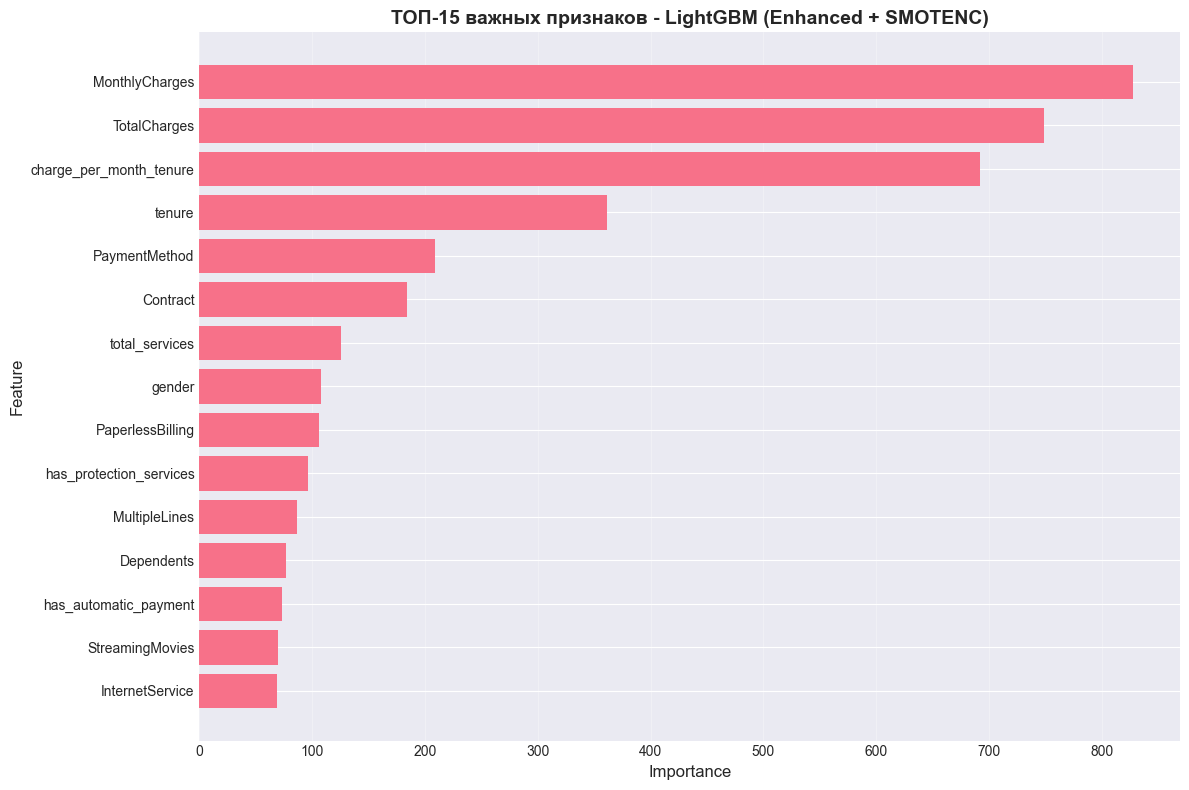

In [63]:
# Визуализация Feature Importance для LightGBM
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_lgbm.head(15)['feature'], feature_importance_lgbm.head(15)['importance'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('ТОП-15 важных признаков - LightGBM (Enhanced + SMOTENC)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [67]:
# 3. Logistic Regression (Base) - для сравнения (интерпретируемая модель)
print("\n МОДЕЛЬ #3: Logistic Regression (Base) - для сравнения")

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Масштабирование данных
scaler_lr = StandardScaler()
X_train_base_scaled = scaler_lr.fit_transform(X_train_base_simple_ohe)
X_test_base_scaled = scaler_lr.transform(X_test_base_simple_ohe)

logreg_final = LogisticRegression(
    C=0.01,
    penalty='l2',
    solver='liblinear',
    random_state=42,
    max_iter=1000
)

logreg_final.fit(X_train_base_scaled, y_train_base_simple)

# Feature importance (коэффициенты)
feature_importance_logreg = pd.DataFrame({
    'feature': X_base_ohe_encoded.columns,
    'importance': abs(logreg_final.coef_[0])  # Берем абсолютные значения
}).sort_values('importance', ascending=False)

print(f"\nТОП-15 важных признаков для Logistic Regression:")
print(feature_importance_logreg.head(15).to_string(index=False))

# Метрики
y_pred_lr = logreg_final.predict(X_test_base_scaled)
y_pred_proba_lr = logreg_final.predict_proba(X_test_base_scaled)[:, 1]

print(f"\n Метрики на тестовой выборке:")
print(f"   Accuracy:  {accuracy_score(y_test_base_simple, y_pred_lr):.4f}")
print(f"   Precision: {precision_score(y_test_base_simple, y_pred_lr):.4f}")
print(f"   Recall:    {recall_score(y_test_base_simple, y_pred_lr):.4f} (низкий!)")
print(f"   F1-Score:  {f1_score(y_test_base_simple, y_pred_lr):.4f}")
print(f"   ROC-AUC:   {roc_auc_score(y_test_base_simple, y_pred_proba_lr):.4f}")


 МОДЕЛЬ #3: Logistic Regression (Base) - для сравнения

ТОП-15 важных признаков для Logistic Regression:
                       feature  importance
                        tenure    0.502897
             Contract_Two year    0.354177
   InternetService_Fiber optic    0.317923
             Contract_One year    0.222987
            OnlineSecurity_Yes    0.183057
PaymentMethod_Electronic check    0.156814
                  TotalCharges    0.156106
               TechSupport_Yes    0.154328
          PaperlessBilling_Yes    0.143092
                MonthlyCharges    0.125356
           StreamingMovies_Yes    0.114584
             MultipleLines_Yes    0.095197
              OnlineBackup_Yes    0.083516
               StreamingTV_Yes    0.075042
                Dependents_Yes    0.069721

 Метрики на тестовой выборке:
   Accuracy:  0.8162
   Precision: 0.6707
   Recall:    0.6005 (низкий!)
   F1-Score:  0.6337
   ROC-AUC:   0.8601


In [ ]:
# Визуализация Feature Importance для Logistic Regression
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_logreg.head(15)['feature'], feature_importance_logreg.head(15)['importance'])
plt.xlabel('Importance (|Coefficient|)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('ТОП-15 важных признаков - Logistic Regression (Base)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

###  Ключевые выводы по Feature Importance

**Самые важные факторы оттока (общие для всех моделей):**

1. **Контракт (Contract)** - тип контракта клиента
   - Month-to-month контракты имеют самый высокий риск оттока
   - Долгосрочные контракты (1-2 года) удерживают клиентов

2. **Tenure (срок обслуживания)** - как долго клиент с компанией
   - Новые клиенты (0-12 месяцев) чаще уходят
   - Чем дольше клиент с компанией, тем ниже вероятность оттока

3. **Monthly Charges (ежемесячный платеж)**
   - Высокие платежи коррелируют с оттоком
   - Клиенты с низкими тарифами более лояльны

4. **Total Charges (общая сумма платежей)**
   - Связано с tenure - долгосрочные клиенты платят больше в сумме

5. **Internet Service (тип интернета)**
   - Fiber optic клиенты чаще уходят (возможно из-за высокой цены)
   - Клиенты без интернета более стабильны

6. **Payment Method (способ оплаты)**
   - Electronic check - высокий риск
   - Automatic payment - низкий риск (удобство)

7. **Tech Support & Online Security**
   - Отсутствие дополнительных услуг увеличивает отток

---

### Рекомендации для retention-стратегии:

1. **Фокус на новых клиентах** (tenure < 12 месяцев)
   - Специальные бонусы в первый год
   - Программа адаптации

2. **Стимулировать переход на долгосрочные контракты**
   - Скидки за годовой/двухгодичный контракт
   - Бонусы при продлении

3. **Оптимизация цен для Fiber optic**
   - Пакетные предложения
   - Дополнительные услуги в тариф

4. **Автоматизация платежей**
   - Скидка за автоплатеж
   - Уход от electronic check

5. **Upsell дополнительных услуг**
   - Tech Support
   - Online Security
   - Device Protection

### 16. Сохранение лучшей модели

Сохраним финальную модель **AdaBoost** и необходимые артефакты для продакшена.

In [108]:
import joblib
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Создаем директорию, если её нет
os.makedirs('models', exist_ok=True)

# Обучаем финальную модель AdaBoost на Enhanced + SMOTENC
print("🚀 Обучение финальной модели AdaBoost...")

# Используем уже обученную модель из раздела 15
final_model = adaboost_final

# Предсказания на тестовой выборке
y_pred_final = y_pred_ada
y_pred_proba_final = y_pred_proba_ada

# Метрики финальной модели
final_metrics = {
    'accuracy': accuracy_score(y_test_enhanced_smotenc, y_pred_final),
    'precision': precision_score(y_test_enhanced_smotenc, y_pred_final),
    'recall': recall_score(y_test_enhanced_smotenc, y_pred_final),
    'f1': f1_score(y_test_enhanced_smotenc, y_pred_final),
    'roc_auc': roc_auc_score(y_test_enhanced_smotenc, y_pred_proba_final)
}

print("\n📊 Финальные метрики модели:")
for metric, value in final_metrics.items():
    print(f"{metric.upper()}: {value:.4f}")

# Сохраняем модель
model_path = 'models/adaboost_churn_model.pkl'
joblib.dump(final_model, model_path)
print(f"\n✅ Модель успешно сохранена: {model_path}")

# Сохраняем также названия фичей для будущего использования
feature_names_path = 'models/feature_names.pkl'
joblib.dump(X_train_enhanced_smotenc_le.columns.tolist(), feature_names_path)
print(f"✅ Названия фичей сохранены: {feature_names_path}")

# Информация о модели
print(f"\n📦 Информация о модели:")
print(f"   - Алгоритм: AdaBoost Classifier")
print(f"   - Количество фичей: {X_train_enhanced_smotenc_le.shape[1]}")
print(f"   - Обучающая выборка: {X_train_enhanced_smotenc_le_resampled.shape[0]} семплов (с SMOTENC)")
print(f"   - Тестовая выборка: {X_test_enhanced_smotenc_le.shape[0]} семплов")
print(f"   - Recall: {final_metrics['recall']:.1%}")
print(f"   - F1-Score: {final_metrics['f1']:.3f}")
print(f"   - Приоритет: Максимизация Recall (минимизация False Negatives)")

🚀 Обучение финальной модели AdaBoost...

📊 Финальные метрики модели:
ACCURACY: 0.7637
PRECISION: 0.5352
RECALL: 0.8150
F1: 0.6461
ROC_AUC: 0.8538

✅ Модель успешно сохранена: models/adaboost_churn_model.pkl
✅ Названия фичей сохранены: models/feature_names.pkl

📦 Информация о модели:
   - Алгоритм: AdaBoost Classifier
   - Количество фичей: 25
   - Обучающая выборка: 8276 семплов (с SMOTENC)
   - Тестовая выборка: 1409 семплов
   - Recall: 81.5%
   - F1-Score: 0.646
   - Приоритет: Максимизация Recall (минимизация False Negatives)


#### Использование модели

```python
# Загрузка модели
import joblib
model = joblib.load('models/adaboost_churn_model.pkl')
feature_names = joblib.load('models/feature_names.pkl')

# Предсказание для новых данных
predictions = model.predict(new_data)
probabilities = model.predict_proba(new_data)[:, 1]

# Рекомендация: Используйте threshold=0.35 для максимизации Recall
# (если цена потери клиента >> цены retention-кампании)
```